In [3]:
import straxen

2025-06-27 09:58:54,368 - admix - WARNING - Initializing utilix DB failed. You cannot do database operations


DB initialization failed


In [35]:
from straxen.config.url_config import URLConfig
run_id="000000"
url =f"xedocs://electron_drift_velocities?attr=value&run_id={run_id}&version=ONLINE"
electron_drift_velocity = URLConfig.evaluate_dry(url) # in cm /ns 
electron_drift_velocity = electron_drift_velocity * 1e9 # in cm/s
min_L = 0.5
max_L = 100
mean_L = 25
t_max = max_L / electron_drift_velocity
t_mean = mean_L / electron_drift_velocity
t_min = min_L / electron_drift_velocity
print(f"t_max: {t_max} s")
print(f"t_mean: {t_mean} s")

D_t = 34.625 # cm^2/s

sigma_max = (2 * D_t * t_max) ** 0.5
sigma_mean = (2 * D_t * t_mean) ** 0.5
sigma_min = (2 * D_t * t_min) ** 0.5
print(f"sigma_max: {sigma_max} cm")
print(f"sigma_mean: {sigma_mean} cm")


t_max: 0.0011327620234811901 s
t_mean: 0.00028319050587029753 s
sigma_max: 0.2800781500332941 cm
sigma_mean: 0.14003907501664706 cm


In [2]:
# Construct Gaussian Image kernel
from scipy.stats import norm
import numpy as np

def make_gauss_kernel(sigma, pixel_size, percentile=0.99):
    # z such that P[−z≤N(0,1)≤+z] = percentile
    z = norm.ppf((1 + percentile)/2)          # ≈2.576 for percentile=0.99
    # radius in pixels
    r = int(np.ceil(z * sigma / pixel_size))
    # coordinates in meters
    x = np.arange(-r, r+1) * pixel_size
    # 1-D Gaussian (unnormalized)
    g1 = np.exp(-0.5*(x/sigma)**2)
    g1 /= g1.sum()                             # normalize 1-D
    # outer product → 2-D and renormalize
    g2 = np.outer(g1, g1)
    g2 /= g2.sum()
    return g1#g2

dx = 0.0304/2 / 8
kernel_max = make_gauss_kernel(sigma_max, dx)
kernel_mean = make_gauss_kernel(sigma_mean, dx)
kernel_min = make_gauss_kernel(sigma_min, dx)

In [1]:
from numba import njit, prange
import numpy as np
@njit()
def simulate_photons(x0, y0, n_photons=100_000,
                     pitch=0.5, wire_radius=0.0304/2,
                     grid_z=0.027, det_z=6.858, # Height of PMTs for coordinate system with anode mesh at z = 0 
                     det_radius=7.62/2):
    """
    Simulate n_photons emitted isotropically upward from (x0,y0,0).
    Returns (n_hit_detector, n_hit_wire).
    
    Assumes wires at z=grid_z run parallel to y-axis every 'pitch' in x,
    each of radius 'wire_radius'.
    """
    # 1) sample directions uniform on upward hemisphere
    #    cosθ ∈ [0,1], φ ∈ [0,2π)
    cos_theta = np.random.rand(n_photons)
    sin_theta = np.sqrt(1 - cos_theta**2)
    phi       = np.random.rand(n_photons) * 2*np.pi
    dx = sin_theta * np.cos(phi)
    dy = sin_theta * np.sin(phi)
    dz = cos_theta

    """Sample only shooting at PMT"""
    #u    = np.random.rand(n_photons)
    #r    = det_radius * np.sqrt(u)
    #phi2 = np.random.rand(n_photons) * 2*np.pi
    #x_t  = x0 + r * np.cos(phi2)
    #y_t  = y0 + r * np.sin(phi2)
    # direction vector before normalization
    #dx0 = x_t - x0
    #dy0 = y_t - y0
    #dz0 = det_z
    #norm = np.sqrt(dx0**2 + dy0**2 + dz0**2)
    #dx, dy, dz = dx0/norm, dy0/norm, dz0/norm

    # 2) intersection with wire plane at z = grid_z
    t_mesh = grid_z / dz
    x_mesh = x0 + t_mesh * dx
    # wires at x = k*pitch; check min distance in x to nearest wire
    x_mod  = np.mod(x_mesh + pitch/2, pitch) - pitch/2
    hit_wire = np.abs(x_mod) <= wire_radius

    # 3) for those *not* hitting wires, check detector plane at z = det_z
    t_det = det_z / dz
    x_det = x0 + t_det * dx
    y_det = y0 + t_det * dy
    hit_det = (~hit_wire) & ((x_det**2 + y_det**2) <= det_radius**2)

    return np.count_nonzero(hit_det), np.count_nonzero(hit_wire)

@njit(parallel=True)
def doMC(x0, y0):
    nx = x0.shape[0]
    ny = y0.shape[0]
    res = np.empty((x0.shape[0], x0.shape[0], 2), dtype=np.float64)
    for i in prange(nx):
        xi = xs[i]
        for j in prange(ny):
            yj = y0[j]
            n_det, n_wire = simulate_photons(xi, yj)
            res[i,j, 0] = n_det
            res[i,j, 1] = n_wire
    return res



# Grid setup
# 1 =2.4s, 0.1 = 
dx = 0.0304/2 / 2
x_min = -7.62 * 3/2
x_max = 7.62 * 3/2
xs = np.arange(x_min, x_max+dx/2, dx)
ys = xs.copy()

# Compute heatmap
res = doMC(xs, ys)
np.savez('heatmap.npy', res)

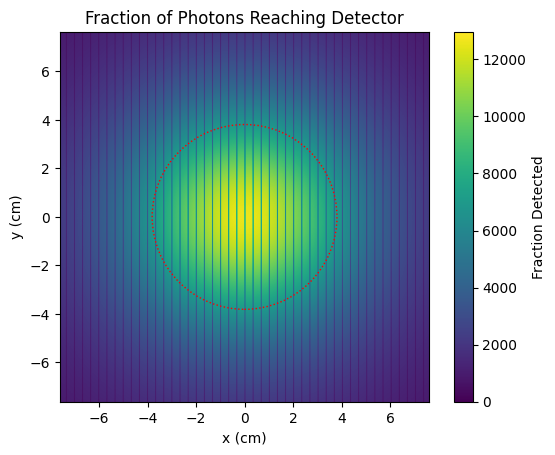

In [6]:
import matplotlib.pyplot as plt 
# Plot
plt.figure()
x_min = -7.62
x_max = 7.62
res = np.load('heatmap.npy.npz')['arr_0']
heatmap = res[:,:, 0] 
plt.imshow(heatmap.T, extent=[x_min, x_max, x_min, x_max,], origin='lower', aspect='equal')
plt.xlabel('x (cm)')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.ylabel('y (cm)')
plt.title('Fraction of Photons Reaching Detector')
plt.colorbar(label='Fraction Detected')

# Plot a circle
from matplotlib.patches import Circle
circle = Circle((0, 0), 7.62/2, color='r',ls=":", fill=False)
# Apply cirlce to the plot
plt.gca().add_patch(circle)

plt.show()


In [7]:
# Reload the heatmap image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img = np.load('heatmap.npy.npz')['arr_0']
heatmap = np.array(img[:,:,0])
dx = 0.0304/2 / 2
x_min = -7.62 * 3/2
x_max = 7.62 * 3/2
xs = np.arange(x_min, x_max+dx/2, dx)
ys = xs.copy()
Nx, Ny = xs.size, ys.size
R= 7.62/2
# We embed it in a larger frame
R2    = 1.5 * R
xs2 = xs.copy()
ys2 = xs.copy()
Nx2, Ny2 = xs2.size, ys2.size

frame = heatmap


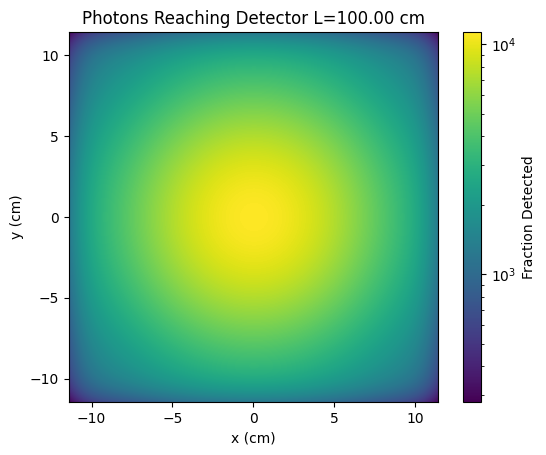

In [8]:
import matplotlib.pyplot as plt 
# Plot
from matplotlib.colors import LogNorm
plt.figure()
# Apply kernel max to heatmap
from scipy.ndimage import convolve1d
plt.imshow(convolve1d(
            convolve1d(frame, kernel_max, axis=1, mode='constant', cval=0.0),
            kernel_max, axis=0, mode='constant', cval=0.0).T, 
           extent=[x_min, x_max, x_min, x_max,], origin='lower', aspect='equal',
           norm=LogNorm())
plt.xlabel('x (cm)')

plt.ylabel('y (cm)')
plt.title('Photons Reaching Detector L={:.2f} cm'.format(max_L))
plt.colorbar(label='Fraction Detected')
plt.show()


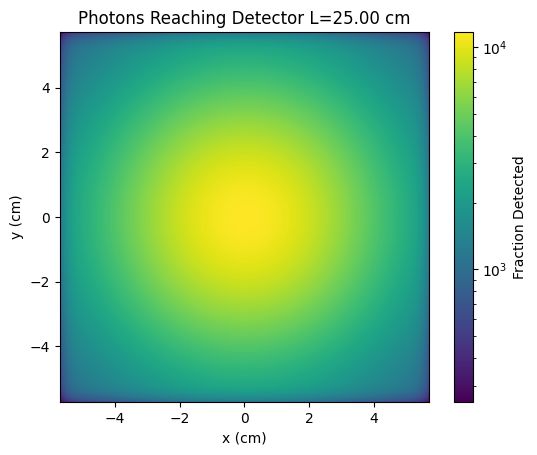

In [9]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
# Plot
plt.figure()
# Apply kernel max to heatmap
from scipy.ndimage import convolve1d
plt.imshow(convolve1d(
            convolve1d(frame, kernel_mean, axis=1, mode='constant', cval=0.0),
            kernel_mean, axis=0, mode='constant', cval=0.0).T, 
           extent=[-R2, R2, -R2, R2], origin='lower', aspect='equal', 
           norm=LogNorm())
plt.xlabel('x (cm)')

plt.ylabel('y (cm)')
plt.title('Photons Reaching Detector L={:.2f} cm'.format(mean_L))
plt.colorbar(label='Fraction Detected')
plt.show()


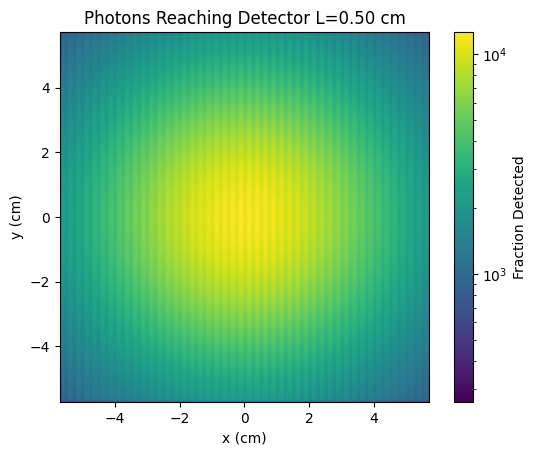

In [10]:
import matplotlib.pyplot as plt 
# Plot
plt.figure()
# Apply kernel max to heatmap
from scipy.ndimage import convolve1d
plt.imshow(convolve1d(
            convolve1d(frame, kernel_min, axis=1, mode='constant', cval=0.0),
            kernel_min, axis=0, mode='constant', cval=0.0).T, 
           extent=[-R2, R2, -R2, R2], origin='lower', aspect='equal',
           norm=LogNorm())

plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.title('Photons Reaching Detector L={:.2f} cm'.format(min_L))
plt.colorbar(label='Fraction Detected')
plt.show()


In [11]:
def ellipse_from_image(I, xs, ys, percentile=0.66):
    from scipy.stats import norm
    """
    Given I[j,i] at grid xs[i], ys[j], compute the principal axes.
    Returns:
      x_c, y_c       centroid
      sigma1, sigma2  RMS half-widths (major, minor)
      angle          orientation of major axis (rad)
      a99, b99       semi-axes of the 99% equivalent Gaussian ellipse
    """
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    M0 = I.sum()
    # centroid
    x_c = (I * X).sum() / M0
    y_c = (I * Y).sum() / M0

    # central moments
    x2 = ((X - x_c)**2 * I).sum() / M0
    y2 = ((Y - y_c)**2 * I).sum() / M0
    xy = (((X - x_c)*(Y - y_c)) * I).sum() / M0

    # covariance matrix
    cov = np.array([[x2, xy],
                    [xy, y2]])
    evals, evecs = np.linalg.eigh(cov)
    # sort so evals[1] >= evals[0]
    order = np.argsort(evals)
    lambda1, lambda2 = evals[order[::-1]]
    vec1 = evecs[:, order[::-1][0]]

    sigma1 = np.sqrt(lambda1)
    sigma2 = np.sqrt(lambda2)
    angle  = np.arctan2(vec1[1], vec1[0])

    # convert to 99% ellipse if desired
    from scipy.stats import norm
    z = norm.ppf((1 + percentile)/2)  # ≈2.576 for 0.99
    a99 = z * sigma1
    b99 = z * sigma2

    return x_c, y_c, sigma1, sigma2, angle, a99, b99


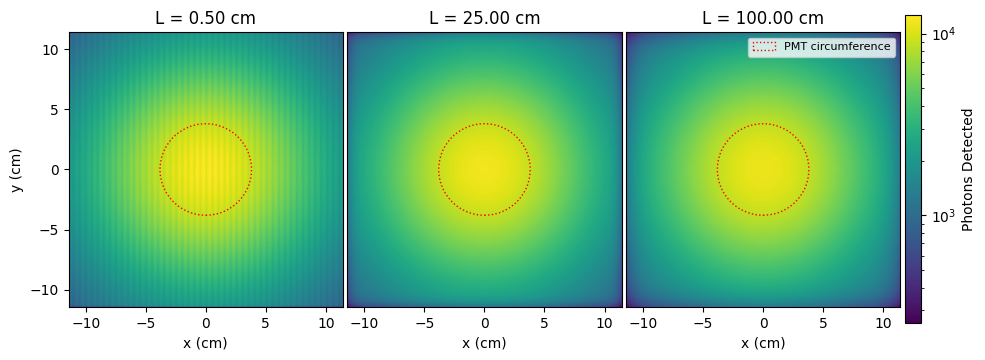

In [12]:
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
# prepare the three convolved maps
kernels = [kernel_min, kernel_mean, kernel_max]
Ls      = [min_L, mean_L, max_L]
titles  = [f'L = {L:.2f} cm' for L in Ls]

maps = []
for kernel in kernels:
    m = convolve1d(convolve1d(frame, kernel, axis=1, mode='constant', cval=0.0),
                   kernel, axis=0, mode='constant', cval=0.0)
    maps.append(m.T)

# find a common LogNorm scale
all_vals = np.hstack([m[np.isfinite(m)].ravel() for m in maps])
norm = LogNorm(vmin=np.min(maps), vmax=np.max(maps), clip=True)

# set up 1×4 grid: 3 plots + narrow colorbar
fig = plt.figure(figsize=(11, 4))
#fig, axes = plt.subplots(1, 4, figsize=(12, 4),
#                         gridspec_kw={'width_ratios': [1,1,1,0.05]},
#                         sharey=True)

# plot each map
axes = np.zeros(4, dtype=object)
gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,0.06], wspace=0.02)

axes[0] = fig.add_subplot(gs[0,0])
axes[1] = fig.add_subplot(gs[0,1], sharey=axes[0])
axes[2] = fig.add_subplot(gs[0,2], sharey=axes[0])

for ax in axes[1:3]:
    ax.get_yaxis().set_visible(False)

for ax, img, title in zip(axes[:3], maps, titles):
    im = ax.imshow(img,
                   extent=[x_min, x_max, x_min, x_max,],
                   origin='lower',
                   aspect='equal',cmap='viridis',
                   norm=norm, )
    ax.set_title(title)
    ax.set_xlabel('x (cm)')
    circle = Circle((0, 0), 7.62/2, color='r',ls=":", fill=False, label='PMT circumference')
    # Apply cirlce to the plot
    ax.add_patch(circle)

axes[0].set_ylabel('y (cm)')

sm = ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])  # dummy
cax = fig.add_subplot(gs[0,3])
cbar = fig.colorbar(sm,
                    ax=axes[:3],   # associate with the three plots
                    cax=cax,   # draw it in the fourth slot
                    label='Photons Detected')

axes[2].legend(loc='upper right', fontsize=8,)

plt.show()


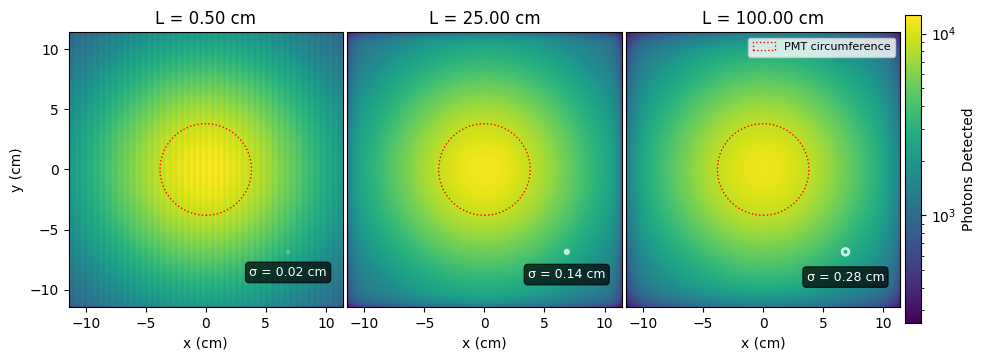

In [18]:
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt

# prepare the three convolved maps
kernels = [kernel_min, kernel_mean, kernel_max]
Ls = [min_L, mean_L, max_L]
sigmas = [sigma_min, sigma_mean, sigma_max]  # Add the sigma values
titles = [f'L = {L:.2f} cm' for L in Ls]
maps = []

for kernel in kernels:
    m = convolve1d(convolve1d(frame, kernel, axis=1, mode='constant', cval=0.0),
                   kernel, axis=0, mode='constant', cval=0.0)
    maps.append(m.T)

# find a common LogNorm scale
all_vals = np.hstack([m[np.isfinite(m)].ravel() for m in maps])
norm = LogNorm(vmin=np.min(maps), vmax=np.max(maps), clip=True)

# set up 1×4 grid: 3 plots + narrow colorbar
fig = plt.figure(figsize=(11, 4))

# plot each map
axes = np.zeros(4, dtype=object)
gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,0.06], wspace=0.02)
axes[0] = fig.add_subplot(gs[0,0])
axes[1] = fig.add_subplot(gs[0,1], sharey=axes[0])
axes[2] = fig.add_subplot(gs[0,2], sharey=axes[0])

for ax in axes[1:3]:
    ax.get_yaxis().set_visible(False)

for ax, img, title, sigma in zip(axes[:3], maps, titles, sigmas):
    im = ax.imshow(img,
                   extent=[x_min, x_max, x_min, x_max],
                   origin='lower',
                   aspect='equal', cmap='viridis',
                   norm=norm)
    ax.set_title(title)
    ax.set_xlabel('x (cm)')
    
    # Add PMT circumference
    circle = Circle((0, 0), 7.62/2, color='r', ls=":", fill=False, label='PMT circumference')
    ax.add_patch(circle)
    
    # Add sigma indicator in bottom right
    # Position it relative to the plot extent
    x_pos = x_max - 0.2 * (x_max - x_min)  # 85% across the plot
    y_pos = x_min + 0.15 * (x_max - x_min)  # 15% up from bottom
    
    # Add circular indicator showing 1σ size
    sigma_circle = Circle((x_pos, y_pos + 0.05 * (x_max - x_min)), sigma, color='white', 
                         fill=False, linewidth=2, alpha=0.8)
    ax.add_patch(sigma_circle)
    
    # Add text label
    ax.text(x_pos, y_pos - 1.5*sigma, f'σ = {sigma:.2f} cm', 
            ha='center', va='top', color='white', fontsize=9, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

axes[0].set_ylabel('y (cm)')

# Create colorbar
sm = ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])  # dummy
cax = fig.add_subplot(gs[0,3])
cbar = fig.colorbar(sm,
                    ax=axes[:3],  # associate with the three plots
                    cax=cax,  # draw it in the fourth slot
                    label='Photons Detected')

axes[2].legend(loc='upper right', fontsize=8)
plt.show()

In [116]:
# Perform Gaussian Fit directly and check uncertainties in x and y 
import numpy as np
from scipy.optimize import curve_fit

# 1) Define 2D Gaussian model for fitting
def gauss2d(coords, A, x0, y0, sigma_x, sigma_y, theta):
    X, Y = coords
    a = (np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2))
    b = (-np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2))
    c = (np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2))
    return (A * np.exp(-(a*(X-x0)**2 + 2*b*(X-x0)*(Y-y0) + c*(Y-y0)**2))).ravel()

# 2) Fit Gaussian to image I and return σ_x, σ_y and their 1σ uncertainties
def fit_gaussian_uncertainty(I, xs, ys, p0=None):
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    if p0 is None:
        # simple initial guess: max, centroid, equal widths, zero angle, min background
        x_c = (I * X).sum() / I.sum()
        y_c = (I * Y).sum() / I.sum()
        sigma_guess = np.sqrt(np.sum(I * ((X-x_c)**2 + (Y-y_c)**2)) / I.sum() / 2)
        p0 = [I.max(), x_c, y_c, sigma_guess, sigma_guess, 0.0]
    popt, pcov = curve_fit(gauss2d, (X, Y), I.ravel(), p0=p0)
    sigma_x_fit, sigma_y_fit = popt[3], popt[4]
    unc_sigma_x, unc_sigma_y = np.sqrt(np.diag(pcov)[3]), np.sqrt(np.diag(pcov)[4])
    return sigma_x_fit, sigma_y_fit, unc_sigma_x, unc_sigma_y

In [117]:
# Perform Poisson Bootstrap

def poisson_bootstrap(I, xs, ys, n_boot=200, percentile=0.99):
    sig_x, sig_y = [], []
    for _ in range(n_boot):
        I_boot = np.random.poisson(lam=I)
        x_c, y_c, s1, s2, ang, a, b = ellipse_from_image(I_boot, xs, ys, percentile)
        sig_x.append(s1)
        sig_y.append(s2)
    return np.array(sig_x), np.array(sig_y)

In [122]:
from scipy.stats import norm
def process_frame(frame, xs, ys, L, D_t, v_drift, dx, percentile=0.99, n_boot=50):
    """Compute ellipse, Gaussian‐fit uncertainties, and Poisson‐bootstrap for one L"""
    # 1) build and apply convolution kernel
    from scipy.stats import norm
    t     = L / v_drift
    sigma = np.sqrt(2 * D_t * t)
    kernel = make_gauss_kernel(sigma, dx)
    conv   = convolve1d(convolve1d(frame, kernel, axis=1, mode='constant', cval=0.0),
                        kernel,     axis=0, mode='constant', cval=0.0)

    # 2) moment‐based ellipse
    xe, ye, s1, s2, theta, a99, b99 = ellipse_from_image(conv, xs, ys, percentile)

    # 3) Gaussian fit uncertainties
    σx_fit, σy_fit, eσx, eσy = fit_gaussian_uncertainty(conv, xs, ys)

    # 4) Poisson bootstrap on RMS widths
    sigx_bs, sigy_bs = poisson_bootstrap(conv, xs, ys, n_boot=n_boot, percentile=percentile)

    return {
        'ellipse':    {'σ1': s1,    'σ2': s2,    'θ': theta,  'a99': a99,  'b99': b99},
        'gauss_fit':  {'σx': σx_fit, 'σy': σy_fit, 'eσx': eσx,  'eσy': eσy},
        'bootstrap':  {'σx_mean': sigx_bs.mean(), 'σx_std': sigx_bs.std(),
                       'σy_mean': sigy_bs.mean(), 'σy_std': sigy_bs.std()}
    }

Ls = [0.5, 10, 20, 30, 50, 100, 120, 200, 300]
results = {
    L: process_frame(frame, xs2, ys2, L, D_t, electron_drift_velocity, dx)
    for L in Ls
}

In [123]:
for L, res in results.items():
    # original moment‐based
    s1 = res['ellipse']['σ1']
    s2 = res['ellipse']['σ2']
    r_mom = s1 / s2

    # Gaussian‐fit values & uncertainties
    sx, sy = res['gauss_fit']['σx'], res['gauss_fit']['σy']
    esx, esy = res['gauss_fit']['eσx'], res['gauss_fit']['eσy']
    r_fit = sx / sy
    e_r_fit = r_fit * np.sqrt((esx/sx)**2 + (esy/sy)**2)

    # Bootstrap values & uncertainties
    mx, ex = res['bootstrap']['σx_mean'], res['bootstrap']['σx_std']
    my, ey = res['bootstrap']['σy_mean'], res['bootstrap']['σy_std']
    r_boot = mx / my
    e_r_boot = r_boot * np.sqrt((ex/mx)**2 + (ey/my)**2)

    print(
        f"L={L}: "
        f"σ₁={s1:.3f}, σ₂={s2:.3f}, σ₁/σ₂={r_mom:.3f} | "
        f"fit σₓ={sx:.3f}±{esx:.3f}, σᵧ={sy:.3f}±{esy:.3f} | "
        f"boot σₓ={mx:.3f}±{ex:.3f}, σᵧ={my:.3f}±{ey:.3f} | "
        f"fit σₓ/σᵧ={r_fit:.3f}±{e_r_fit:.3f}, "
        f"boot σₓ/σᵧ={r_boot:.3f}±{e_r_boot:.3f}"
    )

L=0.5: σ₁=5.297, σ₂=5.295, σ₁/σ₂=1.000 | fit σₓ=5.991±0.001, σᵧ=5.993±0.001 | boot σₓ=5.297±0.000, σᵧ=5.295±0.000 | fit σₓ/σᵧ=1.000±0.000, boot σₓ/σᵧ=1.000±0.000
L=10: σ₁=5.288, σ₂=5.286, σ₁/σ₂=1.000 | fit σₓ=5.981±0.000, σᵧ=5.983±0.000 | boot σₓ=5.288±0.000, σᵧ=5.286±0.000 | fit σₓ/σᵧ=1.000±0.000, boot σₓ/σᵧ=1.000±0.000
L=20: σ₁=5.284, σ₂=5.282, σ₁/σ₂=1.000 | fit σₓ=5.977±0.000, σᵧ=5.979±0.000 | boot σₓ=5.284±0.000, σᵧ=5.282±0.000 | fit σₓ/σᵧ=1.000±0.000, boot σₓ/σᵧ=1.000±0.000
L=30: σ₁=5.280, σ₂=5.279, σ₁/σ₂=1.000 | fit σₓ=5.974±0.000, σᵧ=5.975±0.000 | boot σₓ=5.280±0.000, σᵧ=5.279±0.000 | fit σₓ/σᵧ=1.000±0.000, boot σₓ/σᵧ=1.000±0.000
L=50: σ₁=5.275, σ₂=5.274, σ₁/σ₂=1.000 | fit σₓ=5.970±0.000, σᵧ=5.969±0.000 | boot σₓ=5.275±0.000, σᵧ=5.274±0.000 | fit σₓ/σᵧ=1.000±0.000, boot σₓ/σᵧ=1.000±0.000
L=100: σ₁=5.267, σ₂=5.265, σ₁/σ₂=1.000 | fit σₓ=5.962±0.000, σᵧ=5.963±0.000 | boot σₓ=5.267±0.000, σᵧ=5.265±0.000 | fit σₓ/σᵧ=1.000±0.000, boot σₓ/σᵧ=1.000±0.000
L=120: σ₁=5.264, σ₂=5.263, σ₁/σ₂

In [126]:
def bootstrap_unbroadened(frame, xs, ys, L, D_t, v_drift, dx,
                          n_boot=20, percentile=0.99):
    """Poisson‐bootstrap on raw frame, then convolve and measure σₓ,σᵧ."""
    t     = L / v_drift
    sigma = np.sqrt(2 * D_t * t)
    kernel = make_gauss_kernel(sigma, dx)

    sigx_bs = []
    sigy_bs = []
    for _ in range(n_boot):
        # 1) Poissonize raw frame
        raw_boot = np.random.poisson(lam=frame)

        # 2) apply 1D convs
        conv = convolve1d(convolve1d(raw_boot, kernel, axis=1, mode='constant', cval=0.0),
                          kernel,     axis=0, mode='constant', cval=0.0)

        # 3) measure via moments
        _, _, s1, s2, _, _, _ = ellipse_from_image(conv, xs, ys, percentile)
        sigx_bs.append(s1)
        sigy_bs.append(s2)

    sigx_bs = np.array(sigx_bs)
    sigy_bs = np.array(sigy_bs)
    return sigx_bs, sigy_bs

bootstrap_ratios = {}
for L in Ls:
    sx, sy = bootstrap_unbroadened(frame, xs2, ys2, L, D_t,
                                   electron_drift_velocity, dx,
                                   n_boot=20, percentile=0.99)
    bootstrap_ratios[L] = {
        'sx_mean':  sx.mean(),
        'sx_std':   sx.std(),
        'sy_mean':  sy.mean(),
        'sy_std':   sy.std(),
        'mean_ratio': np.mean(sx/sy),
    }

# 2) updated print loop
for L, br in bootstrap_ratios.items():
    sx_m, sx_e = br['sx_mean'], br['sx_std']
    sy_m, sy_e = br['sy_mean'], br['sy_std']

    # propagate error on the ratio
    ratio     = sx_m / sy_m
    ratio_err = ratio * np.sqrt((sx_e/sx_m)**2 + (sy_e/sy_m)**2)

    print(
        f"L={L}: "
        f"σₓ={sx_m:.3f}±{sx_e:.3f}, "
        f"σᵧ={sy_m:.3f}±{sy_e:.3f}, "
        f"σₓ/σᵧ={ratio:.4f}±{ratio_err:.4f}"
    )

L=0.5: σₓ=5.297±0.000, σᵧ=5.295±0.000, σₓ/σᵧ=1.0005±0.0000
L=10: σₓ=5.288±0.000, σᵧ=5.286±0.000, σₓ/σᵧ=1.0004±0.0000
L=20: σₓ=5.283±0.000, σᵧ=5.282±0.000, σₓ/σᵧ=1.0003±0.0000
L=30: σₓ=5.280±0.000, σᵧ=5.278±0.000, σₓ/σᵧ=1.0003±0.0000
L=50: σₓ=5.275±0.000, σᵧ=5.273±0.000, σₓ/σᵧ=1.0003±0.0000
L=100: σₓ=5.266±0.000, σᵧ=5.265±0.000, σₓ/σᵧ=1.0003±0.0000
L=120: σₓ=5.264±0.000, σᵧ=5.262±0.000, σₓ/σᵧ=1.0002±0.0000
L=200: σₓ=5.256±0.000, σᵧ=5.254±0.000, σₓ/σᵧ=1.0002±0.0000
L=300: σₓ=5.248±0.000, σᵧ=5.247±0.000, σₓ/σᵧ=1.0002±0.0000


In [138]:
import numpy as np

# Adjust for no-convolution baseline before building the table
# Compute percentile once
percentile = 0.99
n_boot_baseline = 200

# 1) Moment‐based baseline
x_c0, y_c0, s1_0, s2_0, th0, a0, b0 = ellipse_from_image(frame, xs2, ys2, percentile)

# 2) Gaussian‐fit baseline
sx0, sy0, esx0, esy0 = fit_gaussian_uncertainty(frame, xs2, ys2)

# 3) Bootstrap on raw frame (no convolution)
sx_bs0 = []
sy_bs0 = []
for _ in range(n_boot_baseline):
    I_boot = np.random.poisson(lam=frame)
    _, _, sb1, sb2, _, _, _ = ellipse_from_image(I_boot, xs2, ys2, percentile)
    if not np.isnan(sb1):
        sx_bs0.append(sb1)
        sy_bs0.append(sb2)
sx_bs0 = np.array(sx_bs0)
sy_bs0 = np.array(sy_bs0)
br0 = {
    'sx_mean': sx_bs0.mean(),
    'sx_std':  sx_bs0.std(),
    'sy_mean': sy_bs0.mean(),
    'sy_std':  sy_bs0.std(),
    'mean_ratio': sx_bs0.mean() / sy_bs0.mean()
}

# 4) Insert 'Raw' entry into results and bootstrap_ratios
results['Raw'] = {
    'ellipse':    {'σ1': s1_0,    'σ2': s2_0},
    'gauss_fit':  {'σx': sx0,     'σy': sy0,     'eσx': esx0, 'eσy': esy0}
}
bootstrap_ratios['Raw'] = br0
results['Raw']['bootstrap'] = bootstrap_ratios['Raw']

# Now build the table as before
# ... (table-building code follows)


In [144]:
from tabulate import tabulate
import numpy as np

# Adjust decimal precision here
precision = 6
fmt = f".{precision}f"

# Define methods and extractors, now returning (mu_x, err_x, mu_y, err_y, r, err_r)
methods = [
    ("Moment Method", lambda res, br: (
        res['ellipse']['σ1'], 0.0,
        res['ellipse']['σ2'], 0.0,
        res['ellipse']['σ1'] / res['ellipse']['σ2'], 0.0
    )),
    ("Gaussian Fit", lambda res, br: (
        res['gauss_fit']['σx'], res['gauss_fit']['eσx'],
        res['gauss_fit']['σy'], res['gauss_fit']['eσy'],
        res['gauss_fit']['σx'] / res['gauss_fit']['σy'],
        (res['gauss_fit']['σx'] / res['gauss_fit']['σy'])
         * np.sqrt((res['gauss_fit']['eσx'] / res['gauss_fit']['σx'])**2
                 + (res['gauss_fit']['eσy'] / res['gauss_fit']['σy'])**2)
    )),
    ("Conv. Bootstrap", lambda res, br: (
        br['sx_mean'], br['sx_std'],
        br['sy_mean'], br['sy_std'],
        br['sx_mean'] / br['sy_mean'],
        (br['sx_mean'] / br['sy_mean'])
         * np.sqrt((br['sx_std'] / br['sx_mean'])**2
                 + (br['sy_std'] / br['sy_mean'])**2)
    )),
    ("Pre-Conv Bootstrap", lambda res, br: (
        br['sx_mean'], br['sx_std'],
        br['sy_mean'], br['sy_std'],
        br['mean_ratio'],
        br['mean_ratio'] * np.sqrt((br['sx_std']/br['sx_mean'])**2
                                 + (br['sy_std']/br['sy_mean'])**2)
    )),
]

# Build headers: L plus for each method 6 columns
headers = ["L"]
for name, _ in methods:
    headers += [
        name + " $\\mu_x$", name + " $\\sigma_{\\mu,x}$",
        name + " $\\mu_y$", name + " $\\sigma_{\\mu,y}$",
        name + " $r$",      name + " $\\sigma_{r}$"
    ]

# Build table rows
numeric_Ls = sorted(k for k in results if isinstance(k, (int, float)))
keys = numeric_Ls + (['Raw'] if 'Raw' in results else [])

table = []
for L in keys:
    res = results[L]
    br  = bootstrap_ratios[L]
    row = [f"{L}"]
    for _, extract in methods:
        mu_x, err_x, mu_y, err_y, r, err_r = extract(res, br)
        row += [
            f"{mu_x:{fmt}}", f"{err_x:{fmt}}",
            f"{mu_y:{fmt}}", f"{err_y:{fmt}}",
            f"{r:{fmt}}",     f"{err_r:{fmt}}"
        ]
    table.append(row)

# Print markdown table for Jupyter
print(tabulate(table, headers, tablefmt="github", floatfmt=fmt))


| L   |   Moment Method $\mu_x$ |   Moment Method $\sigma_{\mu,x}$ |   Moment Method $\mu_y$ |   Moment Method $\sigma_{\mu,y}$ |   Moment Method $r$ |   Moment Method $\sigma_{r}$ |   Gaussian Fit $\mu_x$ |   Gaussian Fit $\sigma_{\mu,x}$ |   Gaussian Fit $\mu_y$ |   Gaussian Fit $\sigma_{\mu,y}$ |   Gaussian Fit $r$ |   Gaussian Fit $\sigma_{r}$ |   Conv. Bootstrap $\mu_x$ |   Conv. Bootstrap $\sigma_{\mu,x}$ |   Conv. Bootstrap $\mu_y$ |   Conv. Bootstrap $\sigma_{\mu,y}$ |   Conv. Bootstrap $r$ |   Conv. Bootstrap $\sigma_{r}$ |   Pre-Conv Bootstrap $\mu_x$ |   Pre-Conv Bootstrap $\sigma_{\mu,x}$ |   Pre-Conv Bootstrap $\mu_y$ |   Pre-Conv Bootstrap $\sigma_{\mu,y}$ |   Pre-Conv Bootstrap $r$ |   Pre-Conv Bootstrap $\sigma_{r}$ |
|-----|-------------------------|----------------------------------|-------------------------|----------------------------------|---------------------|------------------------------|------------------------|---------------------------------|---------------

In [146]:
print(tabulate(table, headers, tablefmt="latex", floatfmt=fmt))

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrr}
\hline
 L   &   Moment Method \$\textbackslash{}mu\_x\$ &   Moment Method \$\textbackslash{}sigma\_\{\textbackslash{}mu,x\}\$ &   Moment Method \$\textbackslash{}mu\_y\$ &   Moment Method \$\textbackslash{}sigma\_\{\textbackslash{}mu,y\}\$ &   Moment Method \$r\$ &   Moment Method \$\textbackslash{}sigma\_\{r\}\$ &   Gaussian Fit \$\textbackslash{}mu\_x\$ &   Gaussian Fit \$\textbackslash{}sigma\_\{\textbackslash{}mu,x\}\$ &   Gaussian Fit \$\textbackslash{}mu\_y\$ &   Gaussian Fit \$\textbackslash{}sigma\_\{\textbackslash{}mu,y\}\$ &   Gaussian Fit \$r\$ &   Gaussian Fit \$\textbackslash{}sigma\_\{r\}\$ &   Conv. Bootstrap \$\textbackslash{}mu\_x\$ &   Conv. Bootstrap \$\textbackslash{}sigma\_\{\textbackslash{}mu,x\}\$ &   Conv. Bootstrap \$\textbackslash{}mu\_y\$ &   Conv. Bootstrap \$\textbackslash{}sigma\_\{\textbackslash{}mu,y\}\$ &   Conv. Bootstrap \$r\$ &   Conv. Bootstrap \$\textbackslash{}sigma\_\{r\}\$ &   Pre-Conv Bootstrap \$\text

# Try anode mesh range emission only

Not included in final thesis

In [22]:
# Reload the heatmap image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img = np.load('heatmap.npy.npz')['arr_0']
heatmap = np.array(img[:,:,0])
dx = 0.0304/2 / 2
x_min = -7.62 * 3/2
x_max = 7.62 * 3/2
xs = np.arange(x_min, x_max+dx/2, dx)
ys = xs.copy()
Nx, Ny = xs.size, ys.size
R= 7.62/2
# We embed it in a larger frame
R2    = 1.5 * R
xs2 = xs.copy()
ys2 = xs.copy()
Nx2, Ny2 = xs2.size, ys2.size

frame = heatmap


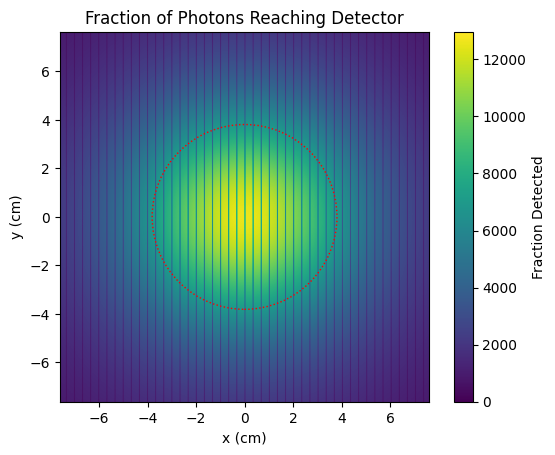

In [23]:
import matplotlib.pyplot as plt 
# Plot
plt.figure()
x_min = -7.62
x_max = 7.62
plt.imshow(heatmap.T, extent=[x_min, x_max, x_min, x_max,], origin='lower', aspect='equal')
plt.xlabel('x (cm)')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.ylabel('y (cm)')
plt.title('Fraction of Photons Reaching Detector')
plt.colorbar(label='Fraction Detected')

# Plot a circle
from matplotlib.patches import Circle
circle = Circle((0, 0), 7.62/2, color='r',ls=":", fill=False)
# Apply cirlce to the plot
plt.gca().add_patch(circle)

plt.show()


In [166]:
import numpy as np
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d

# ——— Your grid ———
dx = 0.0304/2/2
x_min = -7.62 * 3/2
x_max =  7.62 * 3/2
xs = np.arange(x_min, x_max + dx/2, dx)   # shape (3009,)
ys = xs.copy()                            # will use for axis-1
nx, ny = xs.size, ys.size

# ——— Physical parameters ———
L_depth = 50.0                            # mm
from straxen.config.url_config import URLConfig
run_id="000000"
url =f"xedocs://electron_drift_velocities?attr=value&run_id={run_id}&version=ONLINE"
electron_drift_velocity = URLConfig.evaluate_dry(url) # in cm /ns 
electron_drift_velocity = electron_drift_velocity * 1e9 # in cm/s
D_t = 34.625 # cm^2/s                     # transverse diffusion coeff (mm²/μs)

# compute Gaussian σ
t_max = L_depth / electron_drift_velocity
sigma_cloud = np.sqrt(2 * D_t * t_max)

"""
We now apply a gaussian weighting to the heatmap
At every wire we apply this weighting to simulate the higher response close to the anode mesh
So we use a gaussian distribution with very small sigma (anode wire radius)
So that events close to anode wire have higher contributions than between 
"""
from scipy.signal import find_peaks

from scipy.ndimage import maximum_filter

window = 61                  # must be od
data = np.gradient(heatmap[:,3009//2], dx, edge_order=2)
# mark points equal to the local max in ±(window//2)
is_max = data == maximum_filter(data, size=window, mode='constant')
# then restrict to actual peaks
peaks = np.where(is_max & (data > 500))[0] - 2
#find_peaks(data, height=500)[0]
wire_pos = (peaks) * dx
sigma_wire = 0.0304
Δx = xs[:, None] - np.array(wire_pos)[None, :] -x_min
G   = np.exp(- Δx**2 / (2*sigma_wire**2))       # Gaussian around each wire
W   = G.sum(axis=1)   
W += 1e-3   # ← baseline “leakage” away from any wire
W /= W.max()
mod_heatmap = heatmap * W[:, None]  # modulate by wire position
# renormalize
mod_heatmap = mod_heatmap * heatmap.sum() / mod_heatmap.sum()

def make_gauss_kernel(sigma, pixel_size, percentile=0.99):
    from scipy.stats import norm
    # z such that P[−z≤N(0,1)≤+z] = percentile
    z = norm.ppf((1 + percentile)/2)          # ≈2.576 for percentile=0.99
    # radius in pixels
    r = int(np.ceil(z * sigma / pixel_size))
    # coordinates in meters
    x = np.arange(-r, r+1) * pixel_size
    # 1-D Gaussian (unnormalized)
    g1 = np.exp(-0.5*(x/sigma)**2)
    g1 /= g1.sum()                             # normalize 1-D
    # outer product → 2-D and renormalize
    g2 = np.outer(g1, g1)
    g2 /= g2.sum()
    return g1#g2
def tmp(L=10):
    t     = L / electron_drift_velocity
    sigma = np.sqrt(2 * D_t * t)
    kernel = make_gauss_kernel(sigma_cloud, dx)
    return kernel
mod_heatmap =convolve1d(mod_heatmap, tmp(L=10), axis=0, mode='constant', cval=0.0)
mod_heatmap =convolve1d(mod_heatmap, tmp(L=10), axis=1, mode='constant', cval=0.0)

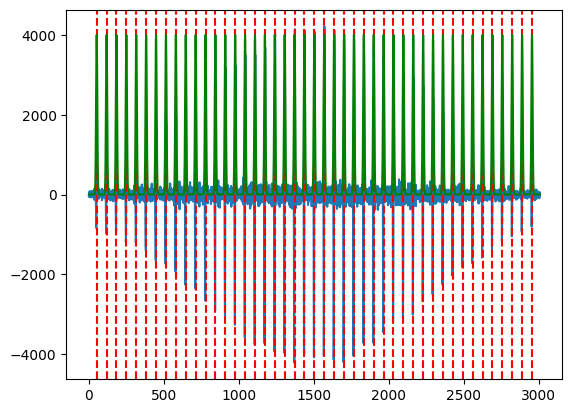

In [167]:
plt.plot(np.diff(((heatmap[:,3009//2]))), label="Gradient")
for i in peaks:
    plt.axvline(i, color='r', ls='--', label="Gradient Maxima")
plt.plot(W*4000, c='g', label="Scaled Gaussian Weighting")

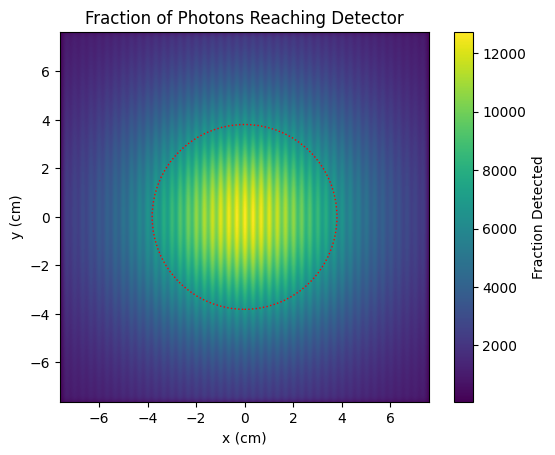

In [168]:
import matplotlib.pyplot as plt 
# Plot
plt.figure()
x_min = -7.62
x_max = 7.62
plt.imshow(mod_heatmap.T, extent=[x_min, x_max, x_min, x_max,], origin='lower', aspect='equal')
plt.xlabel('x (cm)')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.ylabel('y (cm)')
plt.title('Fraction of Photons Reaching Detector')
plt.colorbar(label='Fraction Detected')

# Plot a circle
from matplotlib.patches import Circle
circle = Circle((0, 0), 7.62/2, color='r',ls=":", fill=False)
# Apply cirlce to the plot
plt.gca().add_patch(circle)

plt.show()


In [ ]:
from scipy.optimize import curve_fit
def gauss2d(coords, A, x0, y0, sigma_x, sigma_y, theta):
    X, Y = coords
    a = (np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2))
    b = (-np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2))
    c = (np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2))
    return (A * np.exp(-(a*(X-x0)**2 + 2*b*(X-x0)*(Y-y0) + c*(Y-y0)**2))).ravel()
def fit_gaussian_uncertainty(I, xs, ys, p0=None):
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    if p0 is None:
        # simple initial guess: max, centroid, equal widths, zero angle, min background
        x_c = (I * X).sum() / I.sum()
        y_c = (I * Y).sum() / I.sum()
        sigma_guess = np.sqrt(np.sum(I * ((X-x_c)**2 + (Y-y_c)**2)) / I.sum() / 2)
        p0 = [I.max(), x_c, y_c, sigma_guess, sigma_guess, 0.0]
    popt, pcov = curve_fit(gauss2d, (X, Y), I.ravel(), p0=p0)
    sigma_x_fit, sigma_y_fit = popt[3], popt[4]
    unc_sigma_x, unc_sigma_y = np.sqrt(np.diag(pcov)[3]), np.sqrt(np.diag(pcov)[4])
    return sigma_x_fit, sigma_y_fit, unc_sigma_x, unc_sigma_y
sigma_x_fit, sigma_y_fit, unc_sigma_x, unc_sigma_y =fit_gaussian_uncertainty(mod_heatmap, xs, ys)
# Print x/y and uncertainty
print(f"σₓ = {sigma_x_fit:.3f} ± {unc_sigma_x:.3f}")
print(f"σᵧ = {sigma_y_fit:.3f} ± {unc_sigma_y:.3f}")
# Print ratio and uncertainty
r_fit = sigma_x_fit / sigma_y_fit
e_r_fit = r_fit * np.sqrt((unc_sigma_x/sigma_x_fit)**2 + (unc_sigma_y/sigma_y_fit)**2)
print(f"σₓ/σᵧ = {r_fit:.3f} ± {e_r_fit:.3f}")
# L=10: 1.003
# L=100: 1.003

σₓ = 5.970 ± 0.000
σᵧ = 5.954 ± 0.000
σₓ/σᵧ = 1.003 ± 0.000


In [ ]:
def ellipse_from_image(I, xs, ys, percentile=0.66):
    from scipy.stats import norm
    """
    Given I[j,i] at grid xs[i], ys[j], compute the principal axes.
    Returns:
      x_c, y_c       centroid
      sigma1, sigma2  RMS half-widths (major, minor)
      angle          orientation of major axis (rad)
      a99, b99       semi-axes of the 99% equivalent Gaussian ellipse
    """
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    M0 = I.sum()
    # centroid
    x_c = (I * X).sum() / M0
    y_c = (I * Y).sum() / M0

    # central moments
    x2 = ((X - x_c)**2 * I).sum() / M0
    y2 = ((Y - y_c)**2 * I).sum() / M0
    xy = (((X - x_c)*(Y - y_c)) * I).sum() / M0

    # covariance matrix
    cov = np.array([[x2, xy],
                    [xy, y2]])
    evals, evecs = np.linalg.eigh(cov)
    # sort so evals[1] >= evals[0]
    order = np.argsort(evals)
    lambda1, lambda2 = evals[order[::-1]]
    vec1 = evecs[:, order[::-1][0]]

    sigma1 = np.sqrt(lambda1)
    sigma2 = np.sqrt(lambda2)
    angle  = np.arctan2(vec1[1], vec1[0])

    # convert to 99% ellipse if desired
    from scipy.stats import norm
    z = norm.ppf((1 + percentile)/2)  # ≈2.576 for 0.99
    a99 = z * sigma1
    b99 = z * sigma2

    return x_c, y_c, sigma1, sigma2, angle, a99, b99

x_c, y_c, sigma1, sigma2, angle, a99, b99 =ellipse_from_image(mod_heatmap, xs, ys, percentile=0.66)
# L=100: 1.0036390086543319
# L=10: 1.0036390086543319
sigma1/sigma2

1.0036390086543319

# MC With realistic S2 emission points

simulate_photons : For some x,y,z coordinate count the number of photons reaching the PMT  

sample_z_sigma : Sample a coordinate from the tabulated curves

simulate_cloud : Do n_photons for one cloud



In [3]:
from numba import njit, prange
import numpy as np
from straxen.config.url_config import URLConfig

# For wire switch implementation
run_id="000000"
url =f"xedocs://electron_drift_velocities?attr=value&run_id={run_id}&version=ONLINE"
electron_drift_velocity = URLConfig.evaluate_dry(url) # in cm /ns 
electron_drift_velocity = electron_drift_velocity * 1e9 # in cm/s
mean_L = 75
t_mean = mean_L / electron_drift_velocity

D_t = 34.625 # cm^2/s

sigma_mean = (2 * D_t * t_mean) ** 0.5


@njit()
def simulate_photons(x0, y0, z0,           
                     n_photons=1_000,
                     pitch=0.5, wire_radius=0.0304/2,
                     grid_z=0.83, det_z=7.694, det_radius=7.62/2):
    """
    Emit `n_photons` isotropically into the upper hemisphere from (x0, y0, z0).

    Returns (n_hit_detector, n_hit_wire).

    Wires sit at z = grid_z, run ‖ y-axis, spaced by `pitch`, radius `wire_radius`.
    A single circular PMT of radius `det_radius` is centred on the z-axis at z = det_z.
    """
    # 1) random directions (upper hemisphere)
    cos_theta = np.random.rand(n_photons)          # dz ≥ 0
    sin_theta = np.sqrt(1.0 - cos_theta**2)
    phi       = np.random.rand(n_photons) * 2.0*np.pi
    dx = sin_theta * np.cos(phi)
    dy = sin_theta * np.sin(phi)
    dz = cos_theta

    # 2) intersection with wire plane  (z = grid_z)
    t_mesh = (grid_z - z0) / dz                    # distance to mesh along ray
    x_mesh = x0 + t_mesh * dx
    x_mod  = np.mod(x_mesh + pitch*0.5, pitch) - pitch*0.5
    hit_wire = np.abs(x_mod) <= wire_radius

    # 3) intersection with detector plane (z = det_z)
    t_det = (det_z - z0) / dz
    x_det = x0 + t_det * dx
    y_det = y0 + t_det * dy
    hit_det = (~hit_wire) & ((x_det*x_det + y_det*y_det) <= det_radius*det_radius)

    return np.count_nonzero(hit_det), np.count_nonzero(hit_wire)


@njit()
def sample_z_sigma(cdf, zc, sx, sy):
    u  = np.random.rand()
    k  = np.searchsorted(cdf, u)
    if k == cdf.size:          # protect against u = 1.0
        k -= 1
    return zc[k], sx[k], sy[k]



@njit()
def simulate_cloud(xc, yc, n_electrons, n_photons,
                   pitch, wire_r, grid_z, det_z, det_r,
                   cdf_z, zc, sx_z, sy_z, do_wire_move = False, do_wire_move_variance = sigma_mean, z_weighting = njit(lambda z: 1.0)):
    """
    Returns (n_hit_det, n_hit_wire) for a single cloud.
    The heavy transport work is delegated to simulate_photons().
    """
    hit_det  = 0
    hit_wire = 0

    for _ in range(n_electrons):
        x_do = xc
        if do_wire_move: x_do += do_wire_move_variance * np.random.randn()
        x_wire = np.round(x_do / pitch) * pitch      # axis of nearest anode wire

        # --- sample emission point around that wire -----------------------
        z0, sx, sy = sample_z_sigma(cdf_z, zc, sx_z, sy_z)
        x0 = x_wire + sy * np.random.randn()   # ⟂-to-wire uses σ_Y
        y0 = yc      + sx * np.random.randn()   # ‖-to-wire uses σ_X

        # --- propagate this single photon ---------------------------------
        det, wire = simulate_photons(
            x0, y0, z0,
            n_photons=n_photons,
            pitch=pitch, wire_radius=wire_r,
            grid_z=grid_z, det_z=det_z, det_radius=det_r
        )

        hit_det  += det * z_weighting(z0)
        hit_wire += wire

    return hit_det, hit_wire



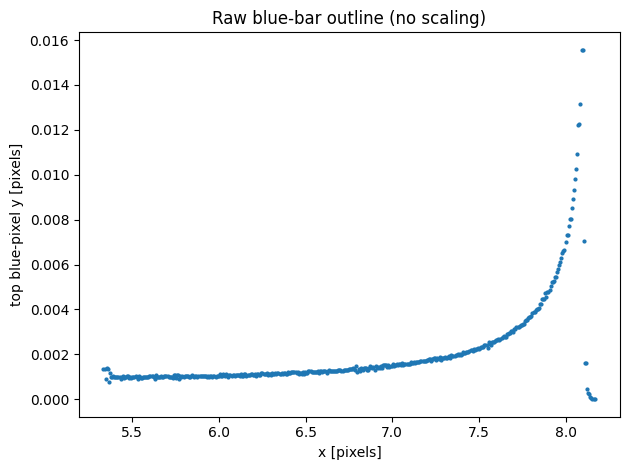

In [25]:
"""
Need to retrieve the points
"""

import numpy as np
from PIL import Image


def px2mm(px, px0, px1, mm0, mm1):
    return (px - px0) / (px1 - px0) * (mm1 - mm0) + mm0


import numpy as np
from PIL import Image

def blue_hist_xy(img_path, blue_thr=120, contrast=50):
    """
    Parameters
    ----------
    img_path : str
        Path to DepthELEmission.png
    Returns
    -------
    x_px : 1-D array  (len = #columns with blue pixels)
    y_px : 1-D array  row index of the first blue pixel from the top
                      (same length as x_px)
    """

    arr = np.asarray(Image.open(img_path).convert('RGB'))
    h, w, _ = arr.shape

    r, g, b = arr[:,:,0], arr[:,:,1], arr[:,:,2]
    blue = np.array((b > blue_thr) & (b - g > contrast) & (b - r > contrast))

    # bounding rectangle that actually contains blue pixels
    cols = np.where(blue.any(axis=0))[0]
    rows = np.where(blue.any(axis=1))[0]
    c0, c1 = cols[0], cols[-1]          # left & right bar limits
    r0, r1 = rows[0], rows[-1]          # top & bottom limits

    x_px = np.arange(c0, c1 + 1)
    y_px = np.empty_like(x_px, dtype=np.float32)


    for i, col in enumerate(x_px):
        col_blue = np.where(blue[:, col])[0]
        y_px[i] = col_blue[0] if col_blue.size else np.nan  # NaN if column empty

    return x_px, y_px


# -------------------------------------------------------------------------
# EXAMPLE USE  (fill the numbers you read in GIMP)
# -------------------------------------------------------------------------
def get_z_prob():
    x_tick_lo, x_tick_hi = 97 , 503    # e.g. 97, 930  (FULL-image columns)
    z_mm_lo,  z_mm_hi    = 5.50, 8.00    # physical values printed on axis
    depth_png = 'ActualThesisWork/ownMCS2EmissionPlots/DepthELEmission.png'
    x_px, y_px = blue_hist_xy(depth_png)

    x_scaled = (x_px - x_tick_lo) * (z_mm_hi - z_mm_lo)/(x_tick_hi - x_tick_lo) + z_mm_lo

    # imagine the printed y-axis says 0 at row y_tick_lo and 0.35 at y_tick_hi
    y_tick_lo_px, y_tick_hi_px =  402,32
    y_val_lo,    y_val_hi     = 0.016,0.000
    scaleperpx = (y_val_hi - y_val_lo) / (y_tick_hi_px - y_tick_lo_px)

    y_scaled = np.abs(y_px - y_tick_lo_px) * scaleperpx
    return x_scaled, y_scaled

z_emission_prob = get_z_prob()
# quick visual check
import matplotlib.pyplot as plt
plt.scatter(z_emission_prob[0],z_emission_prob [1], s=4)
#plt.gca().invert_yaxis()          # so lower y is up
plt.xlabel('x [pixels]'); plt.ylabel('top blue-pixel y [pixels]')
plt.title('Raw blue-bar outline (no scaling)')
plt.tight_layout(); plt.show()



In [31]:

path = 'ActualThesisWork/ownMCS2EmissionPlots'

import os 
z_centres, dens_z = (np.asarray(a, dtype=np.float64) for a in z_emission_prob)
z_centres = z_centres[~np.isnan(dens_z)]
dens_z = dens_z[~np.isnan(dens_z)]
dens_z /= dens_z.sum()                             # normalise
cdf_z  = np.cumsum(dens_z)                         # inverse CDF

# --- σx(z)  and  σy(z)  from the CSVs ----------------------------------------
sigx_tab = np.loadtxt(os.path.join(path, 'xspreadvsz.csv'),
                      delimiter=',', skiprows=1)   # cols: z  σx
sigy_tab = np.loadtxt(os.path.join(path, 'yspreadvsz.csv'),
                      delimiter=',', skiprows=1)   # cols: z  σy

# interpolate
sigma_x_z = np.interp(z_centres, sigx_tab[:, 0], sigx_tab[:, 1]).astype(np.float64)
sigma_y_z = np.interp(z_centres, sigy_tab[:, 0], sigy_tab[:, 1]).astype(np.float64)

# Bring it to cm 
z_centres = z_centres/10


In [115]:

@njit(parallel=True)
def doMC(xs, ys, mask,
         n_electrons = 100,
         n_photons=1_000, 
         pitch=0.5, wire_r=0.0304/2,
         grid_z=0.83, det_z=7.694, det_r=7.62/2,
         cdf_z=cdf_z, zc=z_centres, sx_z=sigma_x_z, sy_z=sigma_y_z):

    nx, ny = xs.size, ys.size
    res = np.full((nx, ny, 2), np.nan, dtype=np.float64)

    for i in prange(nx):
        for j in prange(ny):
            if mask[i, j]:
                det, wire = simulate_cloud(xs[i], ys[j], n_electrons=n_electrons, n_photons=n_photons,
                                        pitch=pitch, wire_r=wire_r, grid_z=grid_z, det_z=det_z, det_r=det_r,
                                        cdf_z=cdf_z, zc=zc, sx_z=sx_z, sy_z=sy_z)
                res[i, j, 0] = det
                res[i, j, 1] = wire
    return res

# Sample Points in positive quadrant of PMT with one extra radius extension
dx           = 0.0304 
max_extent   = 3 * 7.62/2           # 2 × PMT radius  (cm)

xs = np.arange(0.0, max_extent + dx/2, dx)   # 1-D grid in +x
ys = xs.copy()                               # identical for +y
inside = (xs[:,None]**2 + ys[None,:]**2) <= max_extent**2

res = doMC(xs, ys, inside, n_photons=1_000)

np.savez('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission.npz',res)


In [116]:
from straxen.config.url_config import URLConfig
run_id="000000"
url =f"xedocs://electron_drift_velocities?attr=value&run_id={run_id}&version=ONLINE"
electron_drift_velocity = URLConfig.evaluate_dry(url) # in cm /ns 
electron_drift_velocity = electron_drift_velocity * 1e9 # in cm/s
mean_L = 75
t_mean = mean_L / electron_drift_velocity
print(f"t_mean: {t_mean} s")
D_t = 34.625 # cm^2/s
sigma_mean = (2 * D_t * t_mean) ** 0.5
print(f"sigma_mean: {sigma_mean} cm")

t_mean: 0.0008495715176108925 s
sigma_mean: 0.24255479297378213 cm


In [117]:
@njit(parallel=True)
def doMC(xs, ys, mask,
         n_electrons = 100,
         n_photons=1_000, 
         pitch=0.5, wire_r=0.0304/2,
         grid_z=0.83, det_z=7.694, det_r=7.62/2,
         cdf_z=cdf_z, zc=z_centres, sx_z=sigma_x_z, sy_z=sigma_y_z):

    nx, ny = xs.size, ys.size
    res = np.full((nx, ny, 2), np.nan, dtype=np.float64)

    for i in prange(nx):
        for j in prange(ny):
            if mask[i, j]:
                det, wire = simulate_cloud(xs[i], ys[j], n_electrons=n_electrons, n_photons=n_photons,
                                        pitch=pitch, wire_r=wire_r, grid_z=grid_z, det_z=det_z, det_r=det_r,
                                        cdf_z=cdf_z, zc=zc, sx_z=sx_z, sy_z=sy_z, do_wire_move=True, do_wire_move_variance=sigma_mean)
                res[i, j, 0] = det
                res[i, j, 1] = wire
    return res

# Sample Points in positive quadrant of PMT with one extra radius extension
dx           = 0.0304   
max_extent   = 3 * 7.62/2           # 2 × PMT radius  (cm)

xs = np.arange(0.0, max_extent + dx/2, dx)   # 1-D grid in +x
ys = xs.copy()                               # identical for +y
inside = (xs[:,None]**2 + ys[None,:]**2) <= max_extent**2

res = doMC(xs, ys, inside, n_photons=1_000)

np.savez('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch.npz',res)

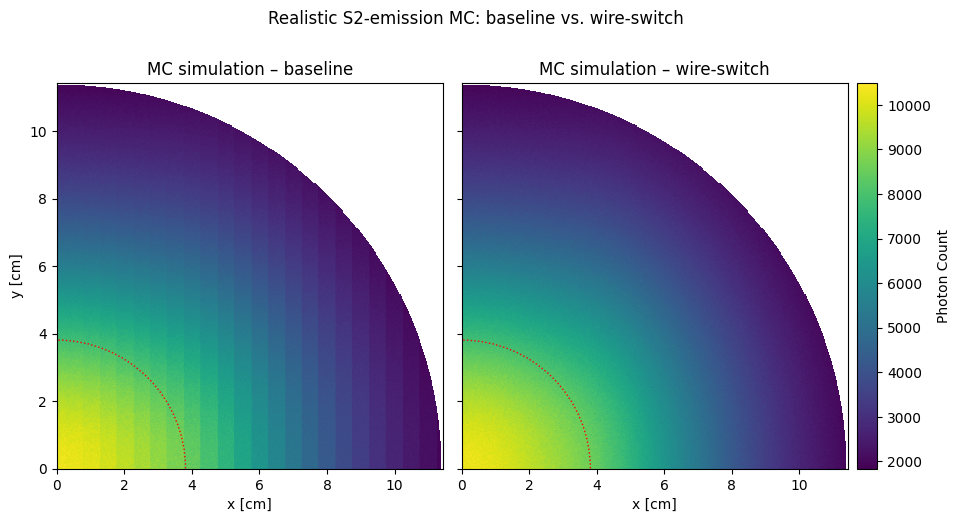

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.gridspec import GridSpec

# ---------------------------------------------------------------------------
# load the two maps
# ---------------------------------------------------------------------------
res1 = np.load('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission.npz')['arr_0']
res2 = np.load('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch.npz')['arr_0']
to_plot1 = res1[:, :, 0]
to_plot2 = res2[:, :, 0]

# common colour scale
vmin = np.nanmin([to_plot1, to_plot2])
vmax = np.nanmax([to_plot1, to_plot2])

titles = [r'MC simulation – baseline', r'MC simulation – wire-switch']
# assume max_extent is defined

# ---------------------------------------------------------------------------
# figure with GridSpec: first two share y-axis and touch; third is narrow cbar
# ---------------------------------------------------------------------------
fig = plt.figure(figsize=(9.8, 5))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
cax = fig.add_subplot(gs[0, 2])

for ax, data, ttl in zip((ax1, ax2), (to_plot1, to_plot2), titles):
    im = ax.imshow(
        data.T,
        extent=[0, max_extent, 0, max_extent],
        origin='lower',
        aspect='equal',
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    ax.add_patch(Circle((0, 0), 7.62/2, ls=':', fill=False, color='r'))
    ax.set_title(ttl)
    ax.set_xlabel('x [cm]')

ax1.set_ylabel('y [cm]')
ax2.tick_params(labelleft=False)  # hide y‐labels on second plot

# shared, minimal colourbar
fig.colorbar(im, cax=cax)
cax.yaxis.set_ticks_position('right')
cax.set_ylabel('Photon Count')

fig.suptitle('Realistic S2‐emission MC: baseline vs. wire-switch', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


In [119]:
np.nanmax((to_plot1 - to_plot2))

662.0

/tmp/ipykernel_79/784565159.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


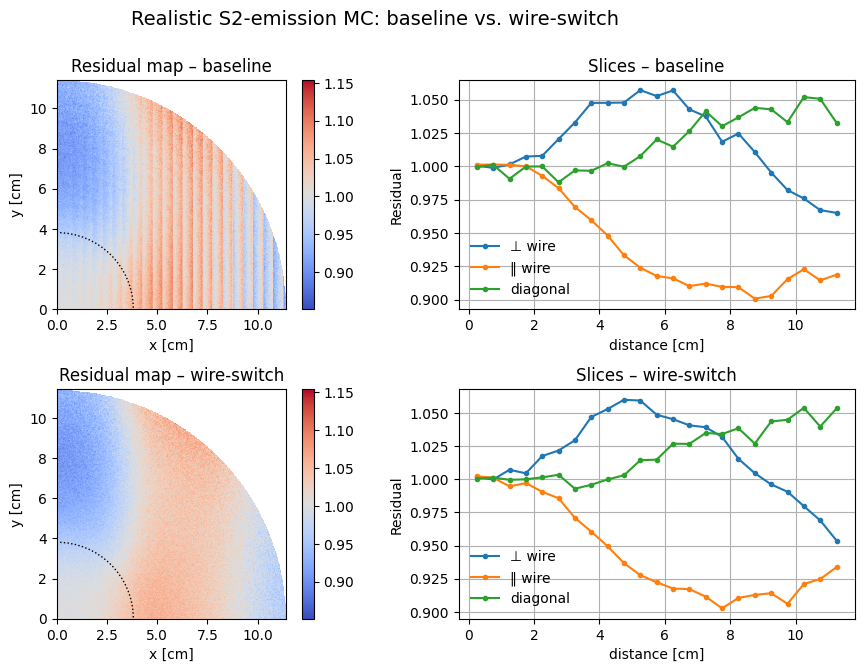

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import PchipInterpolator
det_radius  = 7.62 / 2
# --------------------------------------------------------------------------
# helper to extract residual map + radial curve + 3 binned 1-D slices
# --------------------------------------------------------------------------
def analyse_lce(res, xs, ys, inside, max_extent, det_radius, mesh_pitch=0.5):
    hits = res[:, :, 0].astype(float)
    hits[~inside] = np.nan

    X, Y = np.meshgrid(xs, ys, indexing='ij')
    R    = np.sqrt(X**2 + Y**2)

    # --- radial profile ----------------------------------------------------
    rho     = R[inside].ravel()
    lce     = hits[inside].ravel()
    bins    = np.linspace(0, max_extent, 80)
    r_mid   = 0.5 * (bins[:-1] + bins[1:])
    lce_bin = np.array([np.nanmean(lce[(rho >= lo) & (rho < hi)])
                        for lo, hi in zip(bins[:-1], bins[1:])])
    good    = np.isfinite(lce_bin)

    pchip   = PchipInterpolator(r_mid[good], lce_bin[good])
    radial  = pchip(R)
    residual = hits / radial

    # --- 1-D slices (binned at mesh pitch) ---------------------------------
    def bin_mean(dist, values):
        b = np.arange(0, max_extent + mesh_pitch, mesh_pitch)
        bc = 0.5*(b[:-1] + b[1:])
        idx = np.digitize(dist, b)-1
        out = np.full(bc.size, np.nan)
        for k in range(bc.size):
            sel = idx == k
            if np.any(sel):
                out[k] = np.nanmean(values[sel])
        return bc, out

    slice_perp,  dist_perp  = residual[:, 0], xs
    slice_along, dist_along = residual[0, :], ys
    diag         = np.diag(residual)
    dist_diag    = xs[:diag.size]*np.sqrt(2)

    bp_x, bp = bin_mean(dist_perp,  slice_perp)
    ba_x, ba = bin_mean(dist_along, slice_along)
    bd_x, bd = bin_mean(dist_diag,  diag)

    return residual, (r_mid[good], lce_bin[good], pchip), (bp_x, bp, ba_x, ba, bd_x, bd)

# --------------------------------------------------------------------------
# load the two simulations
# --------------------------------------------------------------------------
res1 = np.load('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission.npz')['arr_0']
res2 = np.load('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch.npz')['arr_0']

# geometry / grid already defined earlier
# xs, ys, inside, max_extent, det_radius are assumed in scope

# analyse both maps
residual1, (r1, lce1, pchip1), (bp1_x, bp1, ba1_x, ba1, bd1_x, bd1) = analyse_lce(
    res1, xs, ys, inside, max_extent, det_radius)

residual2, (r2, lce2, pchip2), (bp2_x, bp2, ba2_x, ba2, bd2_x, bd2) = analyse_lce(
    res2, xs, ys, inside, max_extent, det_radius)

# --------------------------------------------------------------------------
# build a 2-row × 3-column figure (left-to-right: residual, radial, slices)
# --------------------------------------------------------------------------
fig, axes = plt.subplots(
     2, 2, figsize=(12, 7),
     gridspec_kw={'wspace': 0.35, 'hspace': 0.35}
 )
((axA1, axC1), (axA2, axC2)) = axes

vmin = np.nanmin([residual1, residual2])
vmax = np.nanmax([residual1, residual2])

# -- first dataset ----------------------------------------------------------
im1 = axA1.imshow(residual1.T, extent=[0, max_extent, 0, max_extent],
                  origin='lower', aspect='equal', cmap='coolwarm',
                  vmin=vmin, vmax=vmax)
fig.colorbar(im1, ax=axA1, fraction=0.046, pad=0.04)
axA1.add_patch(Circle((0, 0), det_radius, ls=':', fill=False, color='k'))
axA1.set_title('Residual map – baseline')
axA1.set_xlabel('x [cm]'); axA1.set_ylabel('y [cm]')

axC1.plot(bp1_x, bp1, '-o', ms=3, label='⊥ wire')
axC1.plot(ba1_x, ba1, '-o', ms=3, label='‖ wire')
axC1.plot(bd1_x, bd1, '-o', ms=3, label='diagonal')
axC1.set_title('Slices – baseline')
axC1.set_xlabel('distance [cm]'); axC1.set_ylabel('Residual'); axC1.legend(frameon=False)
axC1.grid()
# -- second dataset ---------------------------------------------------------
im2 = axA2.imshow(residual2.T, extent=[0, max_extent, 0, max_extent],
                  origin='lower', aspect='equal', cmap='coolwarm',
                  vmin=vmin, vmax=vmax)
fig.colorbar(im2, ax=axA2, fraction=0.046, pad=0.04)
axA2.add_patch(Circle((0, 0), det_radius, ls=':', fill=False, color='k'))
axA2.set_title('Residual map – wire-switch')
axA2.set_xlabel('x [cm]'); axA2.set_ylabel('y [cm]')

axC2.plot(bp2_x, bp2, '-o', ms=3, label='⊥ wire')
axC2.plot(ba2_x, ba2, '-o', ms=3, label='‖ wire')
axC2.plot(bd2_x, bd2, '-o', ms=3, label='diagonal')
axC2.set_title('Slices – wire-switch')
axC2.set_xlabel('distance [cm]'); axC2.set_ylabel('Residual'); axC2.legend(frameon=False)
axC2.grid()

fig.suptitle('Realistic S2-emission MC: baseline vs. wire-switch', fontsize=14)
plt.tight_layout()
plt.show()

## Electron luminosity increase as we go closer to anode may not be part of the z emission depth file 

In [163]:
z_max = z_centres.max()
z_min = z_centres.min()
@njit()
def z_weighting(z):
    """Returns 0.1 to 1 depending on linear interval in [z_min, z_max]"""
    return (z - z_min) / (z_max - z_min) * 0.95 + 0.05

@njit(parallel=True)
def doMC(xs, ys, mask,
         n_electrons = 100,
         n_photons=1_000, 
         pitch=0.5, wire_r=0.0304/2,
         grid_z=0.83, det_z=7.694, det_r=7.62/2,
         cdf_z=cdf_z, zc=z_centres, sx_z=sigma_x_z, sy_z=sigma_y_z):

    nx, ny = xs.size, ys.size
    res = np.full((nx, ny, 2), np.nan, dtype=np.float64)

    for i in prange(nx):
        for j in prange(ny):
            if mask[i, j]:
                det, wire = simulate_cloud(xs[i], ys[j], n_electrons=n_electrons, n_photons=n_photons,
                                        pitch=pitch, wire_r=wire_r, grid_z=grid_z, det_z=det_z, det_r=det_r,
                                        cdf_z=cdf_z, zc=zc, sx_z=sx_z, sy_z=sy_z, do_wire_move=True, do_wire_move_variance=sigma_mean, z_weighting = z_weighting)
                res[i, j, 0] = det
                res[i, j, 1] = wire
    return res

# Sample Points in positive quadrant of PMT with one extra radius extension
dx           = 0.0304   
max_extent   = 3 * 7.62           # 6 × PMT radius  (cm)

xs = np.arange(0.0, max_extent + dx/2, dx)   # 1-D grid in +x
ys = xs.copy()                               # identical for +y
inside = (xs[:,None]**2 + ys[None,:]**2) <= max_extent**2

res = doMC(xs, ys, inside, n_photons=1_000)

np.savez('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch_z_weighted.npz',res)

NONE OF THE LABELS ARE CORRECT I JUST WANTED THE MAXIMUM ENLARGEMENT ALONG EACH AXIS FOR THIS METHOD AS WELL
Perp Wire Max  1.0756271673546953
Perp Wire Min  0.9503532108671477
Para Wire Max  1.0006700297634674
Para Wire Min  0.8987283041266465
Diag Wire Max  1.0473788001206878
Diag Wire Min  0.8916909854696272


/tmp/ipykernel_169/2410340133.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


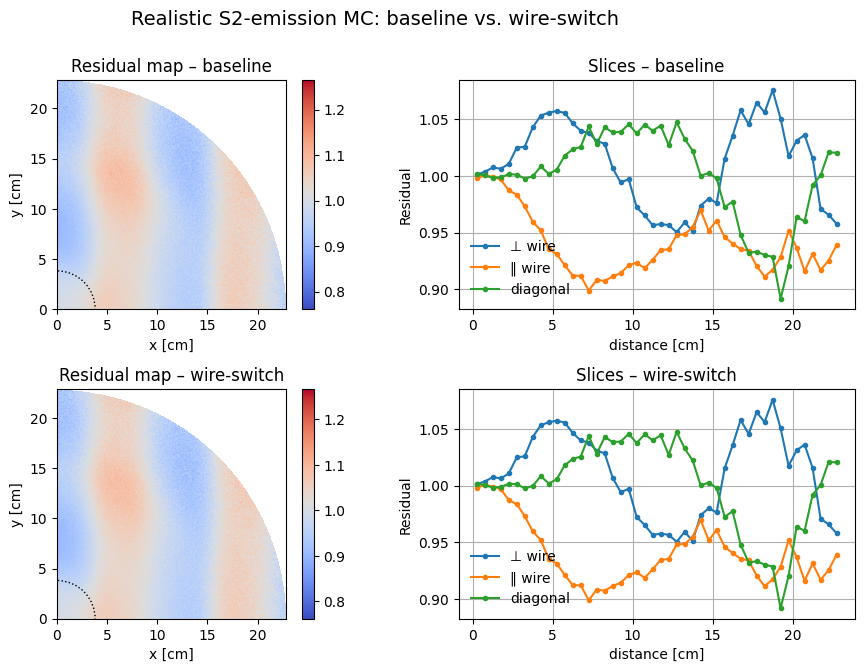

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import RegularGridInterpolator
hits_q = np.load('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch_z_weighted.npz')['arr_0']
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import PchipInterpolator
det_radius  = 7.62 / 2

# Sample Points in positive quadrant of PMT with one extra radius extension
dx           = 0.0304   
max_extent   = 3 * 7.62           # 6 × PMT radius  (cm)

xs = np.arange(0.0, max_extent + dx/2, dx)   # 1-D grid in +x
ys = xs.copy()                               # identical for +y
inside = (xs[:,None]**2 + ys[None,:]**2) <= max_extent**2

print("NONE OF THE LABELS ARE CORRECT I JUST WANTED THE MAXIMUM ENLARGEMENT ALONG EACH AXIS FOR THIS METHOD AS WELL")
# --------------------------------------------------------------------------
# helper to extract residual map + radial curve + 3 binned 1-D slices
# --------------------------------------------------------------------------
def analyse_lce(res, xs, ys, inside, max_extent, det_radius, mesh_pitch=0.5):
    hits = res[:, :, 0].astype(float)
    hits[~inside] = np.nan

    X, Y = np.meshgrid(xs, ys, indexing='ij')
    R    = np.sqrt(X**2 + Y**2)

    # --- radial profile ----------------------------------------------------
    rho     = R[inside].ravel()
    lce     = hits[inside].ravel()
    bins    = np.linspace(0, max_extent, 80)
    r_mid   = 0.5 * (bins[:-1] + bins[1:])
    lce_bin = np.array([np.nanmean(lce[(rho >= lo) & (rho < hi)])
                        for lo, hi in zip(bins[:-1], bins[1:])])
    good    = np.isfinite(lce_bin)

    pchip   = PchipInterpolator(r_mid[good], lce_bin[good])
    radial  = pchip(R)
    residual = hits / radial

    # --- 1-D slices (binned at mesh pitch) ---------------------------------
    def bin_mean(dist, values):
        b = np.arange(0, max_extent + mesh_pitch, mesh_pitch)
        bc = 0.5*(b[:-1] + b[1:])
        idx = np.digitize(dist, b)-1
        out = np.full(bc.size, np.nan)
        for k in range(bc.size):
            sel = idx == k
            if np.any(sel):
                out[k] = np.nanmean(values[sel])
        return bc, out

    slice_perp,  dist_perp  = residual[:, 0], xs
    slice_along, dist_along = residual[0, :], ys
    diag         = np.diag(residual)
    dist_diag    = xs[:diag.size]*np.sqrt(2)

    bp_x, bp = bin_mean(dist_perp,  slice_perp)
    ba_x, ba = bin_mean(dist_along, slice_along)
    bd_x, bd = bin_mean(dist_diag,  diag)

    return residual, (r_mid[good], lce_bin[good], pchip), (bp_x, bp, ba_x, ba, bd_x, bd)

# --------------------------------------------------------------------------
# load the two simulations
# --------------------------------------------------------------------------

# geometry / grid already defined earlier
# xs, ys, inside, max_extent, det_radius are assumed in scope

# analyse both maps
residual1, (r1, lce1, pchip1), (bp1_x, bp1, ba1_x, ba1, bd1_x, bd1) = analyse_lce(
    hits_q, xs, ys, inside, max_extent, det_radius)

residual2, (r2, lce2, pchip2), (bp2_x, bp2, ba2_x, ba2, bd2_x, bd2) = analyse_lce(
    hits_q, xs, ys, inside, max_extent, det_radius)

# --------------------------------------------------------------------------
# build a 2-row × 3-column figure (left-to-right: residual, radial, slices)
# --------------------------------------------------------------------------
fig, axes = plt.subplots(
     2, 2, figsize=(12, 7),
     gridspec_kw={'wspace': 0.35, 'hspace': 0.35}
 )
((axA1, axC1), (axA2, axC2)) = axes

vmin = np.nanmin([residual1, residual2])
vmax = np.nanmax([residual1, residual2])

# -- first dataset ----------------------------------------------------------
im1 = axA1.imshow(residual1.T, extent=[0, max_extent, 0, max_extent],
                  origin='lower', aspect='equal', cmap='coolwarm',
                  vmin=vmin, vmax=vmax)
fig.colorbar(im1, ax=axA1, fraction=0.046, pad=0.04)
axA1.add_patch(Circle((0, 0), det_radius, ls=':', fill=False, color='k'))
axA1.set_title('Residual map – baseline')
axA1.set_xlabel('x [cm]'); axA1.set_ylabel('y [cm]')

axC1.plot(bp1_x, bp1, '-o', ms=3, label='⊥ wire')
axC1.plot(ba1_x, ba1, '-o', ms=3, label='‖ wire')
axC1.plot(bd1_x, bd1, '-o', ms=3, label='diagonal')
axC1.set_title('Slices – baseline')
axC1.set_xlabel('distance [cm]'); axC1.set_ylabel('Residual'); axC1.legend(frameon=False)
axC1.grid()
# -- second dataset ---------------------------------------------------------
im2 = axA2.imshow(residual2.T, extent=[0, max_extent, 0, max_extent],
                  origin='lower', aspect='equal', cmap='coolwarm',
                  vmin=vmin, vmax=vmax)
fig.colorbar(im2, ax=axA2, fraction=0.046, pad=0.04)
axA2.add_patch(Circle((0, 0), det_radius, ls=':', fill=False, color='k'))
axA2.set_title('Residual map – wire-switch')
axA2.set_xlabel('x [cm]'); axA2.set_ylabel('y [cm]')

axC2.plot(bp2_x, bp2, '-o', ms=3, label='⊥ wire')
print("Perp Wire Max ", bp2.max())
print("Perp Wire Min ", bp2.min())
axC2.plot(ba2_x, ba2, '-o', ms=3, label='‖ wire')
print("Para Wire Max ", ba2.max())
print("Para Wire Min ", ba2.min())
axC2.plot(bd2_x, bd2, '-o', ms=3, label='diagonal')
print("Diag Wire Max ", bd2.max())
print("Diag Wire Min ", bd2.min())
axC2.set_title('Slices – wire-switch')
axC2.set_xlabel('distance [cm]'); axC2.set_ylabel('Residual'); axC2.legend(frameon=False)
axC2.grid()

fig.suptitle('Realistic S2-emission MC: baseline vs. wire-switch', fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_460/1262095307.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='upper right')
/tmp/ipykernel_460/1262095307.py:112: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path = cs.collections[0].get_paths()[0]          # the first (and only) closed path
/tmp/ipykernel_460/1262095307.py:118: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path  = cs.collections[0].get_paths()[0]     # closed contour for 66 %


66 % contour width along y = 0 : 13.376 cm
66 % contour height along x = 0 : 11.981 cm
0.8957070707070707


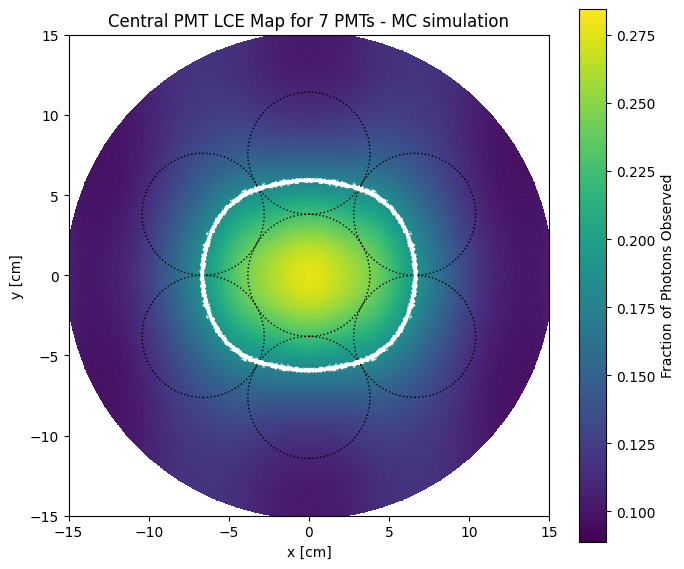

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import RegularGridInterpolator
def tmp():
    hits_q = np.load('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch_z_weighted.npz')['arr_0'][:,:,0].copy()

    # ---------------------------------------------------------------------------
    # 0.  full symmetric grid (keep 0 only once)
    # ---------------------------------------------------------------------------
    xs_pos = xs                              # [0,  Δx,  2Δx, …]
    xs_neg = -xs[1:][::-1]                   # [-Δx, -2Δx, …]  (same length – 1)

    xs_full = np.concatenate((xs_neg, xs_pos))   # length = 2*len(xs)-1
    ys_full = xs_full.copy()

    nxF, nyF = xs_full.size, ys_full.size
    i0 = len(xs_neg)                         # index of x = 0
    j0 = i0                                  # index of y = 0
    r_pmt = 7.62 / 2
    # ---------------------------------------------------------------------------
    # 1.  mirror the quarter-circle map into all four quadrants
    # ---------------------------------------------------------------------------
    full_map = np.full((nxF, nyF), np.nan)

    # positive-x / positive-y (original)
    full_map[i0:, j0:] = hits_q

    # negative-x / positive-y
    full_map[:i0, j0:] = hits_q[1:,:][::-1, :]

    # positive-x / negative-y
    full_map[i0:, :j0] = hits_q[:,1:][:, ::-1]

    # negative-x / negative-y
    full_map[:i0, :j0] = hits_q[1:,1:][::-1, ::-1]

    central_map = full_map
    # ----------------------------------


    # 1) make an interpolator over the full_map
    interp = RegularGridInterpolator(
        (xs_full, ys_full),
        full_map,
        method='linear',       # linear → no oscillation
        bounds_error=False,
        fill_value=np.nan
    )

    # 2) prepare a mesh of all (x,y) points once
    Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
    pts = np.stack([Xg.ravel(), Yg.ravel()], axis=-1)  # (N², 2)

    centres = [(0, 0)]                               # central tube

    R_hex = 2 * r_pmt
    angles = np.deg2rad([30, 90, 150, 210, 270, 330])
    for ang in angles:
        centres.append((R_hex * np.cos(ang), R_hex * np.sin(ang)))

    # 3) for each PMT center, sample the shifted map
    maps = []
    for (xc, yc) in centres:
        # to shift the map by +xc,+yc, we sample at (x - xc, y - yc)
        shifted_pts = pts - np.array([xc, yc])
        shifted_map = interp(shifted_pts).reshape(full_map.shape)
        maps.append(shifted_map)

    # 4) stack and ratio as before
    stack   = np.stack(maps)                     
    tot_map = np.nansum(stack, axis=0)
    ratio   = np.divide(
        maps[0], tot_map,
        out = np.full_like(tot_map, np.nan),
        where=~np.isnan(tot_map)
    )

    X, Y = np.meshgrid(xs_full, ys_full, indexing='ij')

    # 2) create mask for points outside max_extent
    outside = (X**2 + Y**2) > (2 * 7.62 )**2
    ratio[outside] = np.nan
    # --------------------------------------------------------------------------
    # 4.  plot
    # --------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(7, 6))

    im = ax.imshow(ratio.T,
                extent=[xs_full[0], xs_full[-1], ys_full[0], ys_full[-1]],
                origin='lower', aspect='equal', cmap='viridis',
                vmin=np.nanmin(ratio), vmax=np.nanmax(ratio), interpolation='bilinear')
    fig.colorbar(im, ax=ax, label='Fraction of Photons Observed')

    # draw rims
    for (xc, yc) in centres:
        ax.add_patch(Circle((xc, yc), r_pmt, fill=False, ls=':', color='k'))

    # --------------------------------------------------------------------------
    # 5.  66 % enclosed-signal contour for the CENTRAL map
    # --------------------------------------------------------------------------
    vals   = central_map[~np.isnan(central_map)].ravel()
    vals   = np.sort(vals)[::-1]                       # brightest → darkest
    cum    = np.cumsum(vals)
    thr    = vals[np.searchsorted(cum, 0.33 * cum[-1])]   # flux threshold

    # isolate the region whose central-tube value ≥ threshold
    cs = ax.contour(xs_full, ys_full, central_map.T,
                    levels=[thr], colors='w', linewidths=1.5)

    ax.legend(frameon=False, loc='upper right')
    path = cs.collections[0].get_paths()[0]          # the first (and only) closed path
    verts = path.vertices                            # (N, 2) array  [x, y]

    tol = dx / 2                                     # half-grid tolerance
    on_axis = np.isclose(verts[:, 1], 0.0, atol=tol) # points with y ≈ 0

    path  = cs.collections[0].get_paths()[0]     # closed contour for 66 %
    verts = path.vertices                        # (N, 2) points [x, y] in cm
    tol   = dx / 2                               # half-grid tolerance (~0.015 cm)

    # —— horizontal diameter  (intersections with  y ≈ 0) ——————
    on_y0 = np.isclose(verts[:, 1], 0.0, atol=tol)
    if np.any(on_y0):
        xs_axis    = verts[on_y0, 0]
        diam_y0_cm = xs_axis.max() - xs_axis.min()
        print(f"66 % contour width along y = 0 : {diam_y0_cm:.3f} cm")
    else:
        print("Contour does not cross y = 0")

    # —— vertical diameter  (intersections with  x ≈ 0) ————————
    on_x0 = np.isclose(verts[:, 0], 0.0, atol=tol)
    if np.any(on_x0):
        ys_axis    = verts[on_x0, 1]
        diam_x0_cm = ys_axis.max() - ys_axis.min()
        print(f"66 % contour height along x = 0 : {diam_x0_cm:.3f} cm")
    else:
        print("Contour does not cross x = 0")
    print(diam_x0_cm/diam_y0_cm)
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_title('Central PMT LCE Map for 7 PMTs - MC simulation')
    plt.tight_layout()
    plt.show()
    return ratio
ratio_MC = tmp()

/tmp/ipykernel_169/3173665242.py:185: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if len(cs_33.collections[0].get_paths()) > 0:
/tmp/ipykernel_169/3173665242.py:186: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path = cs_33.collections[0].get_paths()[0]


50% contour width along y = 0 : 13.163 cm
50% contour height along x = 0 : 10.780 cm
Aspect ratio (height/width): 0.819


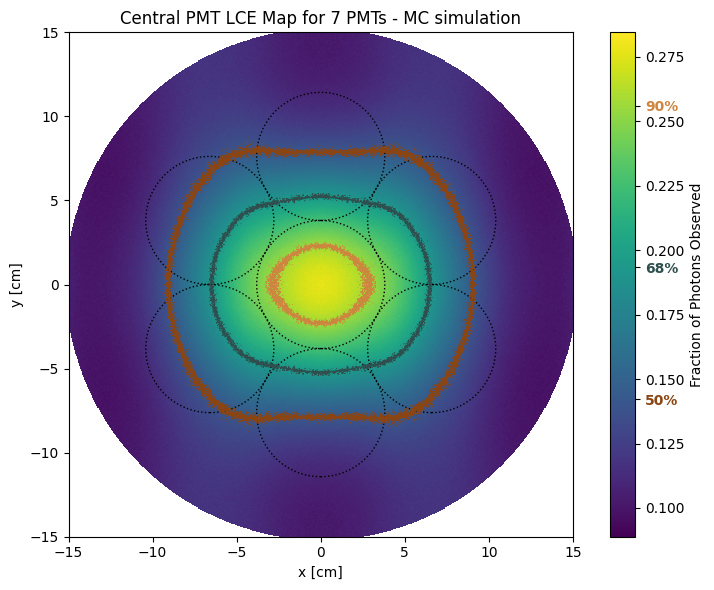

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import RegularGridInterpolator
from matplotlib.lines import Line2D

def tmp():
    try:
        hits_q = np.load('ActualThesisWork/ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch_z_weighted.npz')['arr_0'][:,:,0].copy()
    except:
        hits_q = np.load('ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch_z_weighted.npz')['arr_0'][:,:,0].copy()

    # ---------------------------------------------------------------------------
    # 0.  full symmetric grid (keep 0 only once)
    # ---------------------------------------------------------------------------
    xs_pos = xs                              # [0,  Δx,  2Δx, …]
    xs_neg = -xs[1:][::-1]                   # [-Δx, -2Δx, …]  (same length – 1)

    xs_full = np.concatenate((xs_neg, xs_pos))   # length = 2*len(xs)-1
    ys_full = xs_full.copy()

    nxF, nyF = xs_full.size, ys_full.size
    i0 = len(xs_neg)                         # index of x = 0
    j0 = i0                                  # index of y = 0
    r_pmt = 7.62 / 2
    # ---------------------------------------------------------------------------
    # 1.  mirror the quarter-circle map into all four quadrants
    # ---------------------------------------------------------------------------
    full_map = np.full((nxF, nyF), np.nan)

    # positive-x / positive-y (original)
    full_map[i0:, j0:] = hits_q

    # negative-x / positive-y
    full_map[:i0, j0:] = hits_q[1:,:][::-1, :]

    # positive-x / negative-y
    full_map[i0:, :j0] = hits_q[:,1:][:, ::-1]

    # negative-x / negative-y
    full_map[:i0, :j0] = hits_q[1:,1:][::-1, ::-1]

    central_map = full_map
    # ----------------------------------

    # 1) make an interpolator over the full_map
    interp = RegularGridInterpolator(
        (xs_full, ys_full),
        full_map,
        method='linear',       # linear → no oscillation
        bounds_error=False,
        fill_value=np.nan
    )

    # 2) prepare a mesh of all (x,y) points once
    Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
    pts = np.stack([Xg.ravel(), Yg.ravel()], axis=-1)  # (N², 2)

    centres = [(0, 0)]                               # central tube

    R_hex = 2 * r_pmt
    angles = np.deg2rad([30, 90, 150, 210, 270, 330])
    for ang in angles:
        centres.append((R_hex * np.cos(ang), R_hex * np.sin(ang)))

    # 3) for each PMT center, sample the shifted map
    maps = []
    for (xc, yc) in centres:
        # to shift the map by +xc,+yc, we sample at (x - xc, y - yc)
        shifted_pts = pts - np.array([xc, yc])
        shifted_map = interp(shifted_pts).reshape(full_map.shape)
        maps.append(shifted_map)

    # 4) stack and ratio as before
    stack   = np.stack(maps)                     
    tot_map = np.nansum(stack, axis=0)
    ratio   = np.divide(
        maps[0], tot_map,
        out = np.full_like(tot_map, np.nan),
        where=~np.isnan(tot_map)
    )

    X, Y = np.meshgrid(xs_full, ys_full, indexing='ij')

    # 2) create mask for points outside max_extent
    outside = (X**2 + Y**2) > (2 * 7.62 )**2
    ratio[outside] = np.nan
    
    # --------------------------------------------------------------------------
    # 4.  plot
    # --------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.imshow(ratio.T,
                extent=[xs_full[0], xs_full[-1], ys_full[0], ys_full[-1]],
                origin='lower', aspect='equal', cmap='viridis',
                vmin=np.nanmin(ratio), vmax=np.nanmax(ratio), interpolation='bilinear')
    
    # Create colorbar
    cbar = fig.colorbar(im, ax=ax, label='Fraction of Photons Observed')

    # draw rims
    for (xc, yc) in centres:
        ax.add_patch(Circle((xc, yc), r_pmt, fill=False, ls=':', color='k'))

    # --------------------------------------------------------------------------
    # 5.  Multiple contour levels for the CENTRAL map
    # --------------------------------------------------------------------------
    vals = central_map[~np.isnan(central_map)].ravel()
    vals = np.sort(vals)[::-1]                       # brightest → darkest
    cum = np.cumsum(vals)
    
    # Define multiple contour levels (percentages of enclosed signal)
    #contour_colors = ['cyan', 'orange', 'magenta']
    contour_colors = ['#8B4513', '#2F4F4F', '#CD853F']  # saddle brown, dark slate gray, peru
    contour_labels = ['50%', '68%', '90%']
    
    # Calculate thresholds for each contour level
    contour_sets = []
    max_ratio = np.nanmax(ratio)
    contour_percentages = [0.50, 0.68, 0.9]  # 10%, 33%, 50%, 68%, 90% of max
    thresholds = [pct * max_ratio for pct in contour_percentages]

    # Draw contours of the ratio map (not central_map)
    for i, (threshold, color, label) in enumerate(zip(thresholds, contour_colors, contour_labels)):
        cs = ax.contour(xs_full, ys_full, ratio.T,
                    levels=[threshold], colors=[color], linewidths=0.60)
        contour_sets.append(cs)
    # Draw all contours with thin lines
    contour_sets = []
    for i, (threshold, color, label) in enumerate(zip(thresholds, contour_colors, contour_labels)):
        cs = ax.contour(xs_full, ys_full, ratio.T,
                       levels=[threshold], colors=[color], linewidths=0.60)
        contour_sets.append(cs)
    
    # Note: Colorbar annotations removed to avoid coordinate system issues


    # Add contour level indicators to the colorbar
    # Store the original colorbar limits before modifying ticks
    vmin, vmax = im.get_clim()

    # Add contour level indicators to the colorbar
    cbar_ticks = list(cbar.get_ticks())  # Get existing ticks
    cbar_labels = [f'{tick:.3f}' for tick in cbar_ticks]  # Existing labels

    # Add threshold values as additional ticks
    for threshold, color, label in zip(thresholds, contour_colors, contour_labels):
        if threshold not in cbar_ticks:  # Avoid duplicates
            cbar_ticks.append(threshold)
            cbar_labels.append(f'{label}')

    # Sort ticks and labels together
    tick_label_pairs = list(zip(cbar_ticks, cbar_labels))
    tick_label_pairs.sort(key=lambda x: x[0])
    sorted_ticks, sorted_labels = zip(*tick_label_pairs)

    # Filter ticks to only include those within the colorbar range
    filtered_ticks = []
    filtered_labels = []
    for tick, label in zip(sorted_ticks, sorted_labels):
        if vmin <= tick <= vmax:
            filtered_ticks.append(tick)
            filtered_labels.append(label)

    # Set the ticks and labels
    cbar.set_ticks(filtered_ticks)
    cbar.set_ticklabels(filtered_labels)

    # Restore the original colorbar limits
    im.set_clim(vmin, vmax)

    # Color the threshold tick labels to match contours
    for i, (tick, label) in enumerate(zip(filtered_ticks, filtered_labels)):
        if label in contour_labels:
            color_idx = contour_labels.index(label)
            cbar.ax.get_yticklabels()[i].set_color(contour_colors[color_idx])
            cbar.ax.get_yticklabels()[i].set_fontweight('bold')

    


    # Calculate and print dimensions for the 33% contour (as in original code)
    cs_33 = contour_sets[1]  # 33% contour
    if len(cs_33.collections[0].get_paths()) > 0:
        path = cs_33.collections[0].get_paths()[0]
        verts = path.vertices
        
        tol = dx / 2
        
        # Horizontal diameter (intersections with y ≈ 0)
        on_y0 = np.isclose(verts[:, 1], 0.0, atol=tol)
        if np.any(on_y0):
            xs_axis = verts[on_y0, 0]
            diam_y0_cm = xs_axis.max() - xs_axis.min()
            print(f"{contour_labels[0]} contour width along y = 0 : {diam_y0_cm:.3f} cm")
        else:
            print("{} contour does not cross y = 0".format(contour_labels[0]))

        # Vertical diameter (intersections with x ≈ 0)
        on_x0 = np.isclose(verts[:, 0], 0.0, atol=tol)
        if np.any(on_x0):
            ys_axis = verts[on_x0, 1]
            diam_x0_cm = ys_axis.max() - ys_axis.min()
            print(f"{contour_labels[0]} contour height along x = 0 : {diam_x0_cm:.3f} cm")
            print(f"Aspect ratio (height/width): {diam_x0_cm/diam_y0_cm:.3f}")
        else:
            print("{} contour does not cross x = 0".format(contour_labels[0]))
    
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_title('Central PMT LCE Map for 7 PMTs - MC simulation')
    plt.tight_layout()
    plt.show()
    return ratio

ratio_MC = tmp()

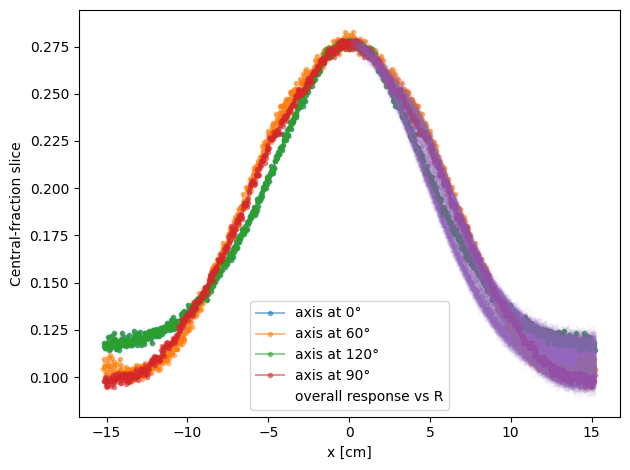

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# assume: ratio (N×N), xs_full (length N), dx defined

# three unique axes through opposite PMTs:
axes_deg = [0, 60, 120, 90]

# index of the central row
i0 = ratio.shape[0] // 2

plt.figure()
for θ in axes_deg:
    # rotate by -θ so that the line at angle θ becomes horizontal
    # order=1 → linear interp, reshape=False → keep same N×N grid
    rot = rotate(ratio, -θ - 30, reshape=False, order=1, mode='constant', cval=np.nan)
    central_slice = rot[i0, :]      # y=0 row after rotation
    plt.plot(xs_full, central_slice, '-o', ms=3, label=f'axis at {θ}°', alpha = 0.5)
Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
plt.plot(
    np.sqrt(Xg[(Xg >= 0) & (Yg >= 0)]**2 + Yg[(Xg >= 0) & (Yg >= 0)]**2),
    ratio[(Xg >= 0) & (Yg >= 0)],
    '.', ms=0.2, alpha=0.3,label='overall response vs R',
)


plt.plot()
plt.xlabel('x [cm]')
plt.ylabel('Central‐fraction slice')
plt.legend()
plt.tight_layout()
plt.show()


## After fitting of Radial LCE

The below three cells is just a paste dump of all of the cells that need to be run (IN ORDER very important tfp does not work otherwise) to ge the model working (half of it is not required)

In [4]:
# Running other things right now change below if you need more 

import os
os.environ["OMP_NUM_THREADS"]  = "21"
os.environ["MKL_NUM_THREADS"]  = "21"
os.environ["OPENBLAS_NUM_THREADS"] = "21"
os.environ["NUMEXPR_NUM_THREADS"]  = "21"
os.sched_setaffinity(0, set(range(21))) 

import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.threading.set_inter_op_parallelism_threads(20)

# Quick Check to be sure
import os
print(os.getcwd())
import socket
import sys
print(socket.gethostname())
print(os.path.isdir('/scratch/midway3/fsemler'))
EXTRACTED_DIR = "/scratch/midway3/fsemler/monotonic-nn-0.3.5"
sys.path.append(EXTRACTED_DIR)
# Change dir
if '/Code' in os.getcwd():
    os.chdir('/Code/ActualThesisWork')
    pass
else:
    os.chdir('/scratch/midway3/fsemler')
print(os.getcwd())
print(os.listdir(os.getcwd()))

2025-06-22 15:00:47.129617: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 15:00:47.147451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-22 15:00:47.147478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-22 15:00:47.148060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-22 15:00:47.151396: I tensorflow/core/platform/cpu_feature_guar

/Code
db30aa633f3c
False
/Code/ActualThesisWork
['CurveFitEntirerLCE.ipynb', 'layer_reimplementation_np.py', 'misc.ipynb', 'MiscPlotting.ipynb', 'reimplementation_verification.ipynb', 'biased_model_full_trained.h5', '__pycache__', 'Train_GCN.ipynb', 'strax_data', 'test_rLCE+MiscComponents.ipynb', 'PMT_calibration.ipynb', 'filtering_data.ipynb', 'Replicate.sync-conflict-20241019-125336-66OAXDZ.ipynb', 'test_rLCE_against_NN.ipynb', 'tpc_structure.ipynb', 'ownMCS2EmissionPlots', 'data', 'NotesOnServer', 'models', 'ShenyangSR2_RadialLCE.ipynb', 'MC_AnodeMesh.ipynb', 'Irrelevant', 'layer_definitions.py', 'README.md', 'CurveFit_FirstBiased.ipynb', 'CurveFit_FirstBiased.sync-conflict-20250429-115302-FF7LCQH.ipynb', 'data.npy', 'process_raw_local.ipynb', 'retrieving_data.ipynb', 'Anode_To_Gate.ipynb', 'NewLoss_NN.ipynb', 'layer_reimplementations_jax.py', 'CurveFitLCEJax.ipynb', 'GeoemetricAndGeneralInvestigation.ipynb', 'functions.py', 'OfficialLCEs.ipynb', 'Old', 's2_map.pkl', 'resource_cache

In [5]:
"""Only in local Docker env not on server -- didnt want to write a docker file as this adds complexity the below should be as reproducible as pip can be 

This has to be the order by the  way otherwise there will be a dependency conflict
"""
%pip install monotonic-nn==0.3.5 # Just cloned it into a dir 
%pip install tensorflow_probability==0.23 # Comes with 04.03.24
%pip install tensorflow_addons==0.23.0
%pip install tensorflow==2.15

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
#
import sys, os
import socket
if socket.gethostname() == 'arch-tower':
    os.environ["XENON_CONFIG"] = "/Code/xenon.config"
#import straxen raises an error something like PID not found for tornado 
import numpy as np
import tensorflow as tf
#tf.config.run_functions_eagerly(True)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
# Monotonically inc/dec Dense Layer 
from airt.keras.layers import MonoDense



sys.path.append(os.getcwd())

from functions import *
# Note some things are dualy defined layer definitions has the up to date
from layer_definitions import *

# Its refusing to download it so i just pasted it from a kernel where it could
pmt_pos_top = np.array([[-1.38753e+01, -6.40872e+01],[-2.08129e+01, -6.00818e+01],[-2.77506e+01, -5.60763e+01],[-3.46882e+01, -5.20709e+01],[-4.16259e+01, -4.80654e+01],[-4.85635e+01, -4.40600e+01],[-1.67313e-05, -6.40872e+01],[-6.93766e+00, -6.00818e+01],[-1.38753e+01, -5.60763e+01],[-2.08129e+01, -5.20709e+01],[-2.77506e+01, -4.80654e+01],[-3.46882e+01, -4.40600e+01],[-4.16259e+01, -4.00545e+01],[-4.85635e+01, -3.60491e+01],[-5.55012e+01, -3.20436e+01],[ 1.38753e+01, -6.40872e+01],[ 6.93763e+00, -6.00818e+01],[-1.46399e-05, -5.60763e+01],[-6.93766e+00, -5.20709e+01],[-1.38753e+01, -4.80654e+01],[-2.08129e+01, -4.40600e+01],[-2.77506e+01, -4.00545e+01],[-3.46882e+01, -3.60491e+01],[-4.16259e+01, -3.20436e+01],[-4.85635e+01, -2.80382e+01],[-5.55012e+01, -2.40327e+01],[-6.24388e+01, -2.00273e+01],[ 2.08129e+01, -6.00818e+01],[ 1.38753e+01, -5.60763e+01],[ 6.93763e+00, -5.20709e+01],[-1.25485e-05, -4.80654e+01],[-6.93766e+00, -4.40600e+01],[-1.38753e+01, -4.00545e+01],[-2.08129e+01, -3.60491e+01],[-2.77506e+01, -3.20436e+01],[-3.46882e+01, -2.80382e+01],[-4.16259e+01, -2.40327e+01],[-4.85635e+01, -2.00273e+01],[-5.55012e+01, -1.60218e+01],[-6.24388e+01, -1.20164e+01],[ 2.77506e+01, -5.60763e+01],[ 2.08129e+01, -5.20709e+01],[ 1.38753e+01, -4.80654e+01],[ 6.93763e+00, -4.40600e+01],[-1.04571e-05, -4.00545e+01],[-6.93765e+00, -3.60491e+01],[-1.38753e+01, -3.20436e+01],[-2.08129e+01, -2.80382e+01],[-2.77506e+01, -2.40327e+01],[-3.46882e+01, -2.00273e+01],[-4.16259e+01, -1.60218e+01],[-4.85635e+01, -1.20164e+01],[-5.55012e+01, -8.01092e+00],[-6.24388e+01, -4.00547e+00],[ 3.46882e+01, -5.20709e+01],[ 2.77506e+01, -4.80654e+01],[ 2.08129e+01, -4.40600e+01],[ 1.38753e+01, -4.00545e+01],[ 6.93763e+00, -3.60491e+01],[-8.36565e-06, -3.20436e+01],[-6.93765e+00, -2.80382e+01],[-1.38753e+01, -2.40327e+01],[-2.08129e+01, -2.00273e+01],[-2.77506e+01, -1.60218e+01],[-3.46882e+01, -1.20164e+01],[-4.16259e+01, -8.01091e+00],[-4.85635e+01, -4.00546e+00],[-5.55012e+01, -1.44897e-05],[-6.24388e+01,  4.00544e+00],[ 4.16259e+01, -4.80654e+01],[ 3.46882e+01, -4.40600e+01],[ 2.77506e+01, -4.00545e+01],[ 2.08129e+01, -3.60491e+01],[ 1.38753e+01, -3.20436e+01],[ 6.93764e+00, -2.80382e+01],[-6.27423e-06, -2.40327e+01],[-6.93765e+00, -2.00273e+01],[-1.38753e+01, -1.60218e+01],[-2.08129e+01, -1.20164e+01],[-2.77506e+01, -8.01091e+00],[-3.46882e+01, -4.00546e+00],[-4.16259e+01, -1.08673e-05],[-4.85635e+01,  4.00544e+00],[-5.55011e+01,  8.01089e+00],[-6.24388e+01,  1.20163e+01],[ 4.85635e+01, -4.40600e+01],[ 4.16259e+01, -4.00545e+01],[ 3.46882e+01, -3.60491e+01],[ 2.77506e+01, -3.20436e+01],[ 2.08129e+01, -2.80382e+01],[ 1.38753e+01, -2.40327e+01],[ 6.93764e+00, -2.00273e+01],[-4.18282e-06, -1.60218e+01],[-6.93765e+00, -1.20164e+01],[-1.38753e+01, -8.01091e+00],[-2.08129e+01, -4.00546e+00],[-2.77506e+01, -7.24486e-06],[-3.46882e+01,  4.00544e+00],[-4.16259e+01,  8.01089e+00],[-4.85635e+01,  1.20163e+01],[-5.55011e+01,  1.60218e+01],[-6.24388e+01,  2.00272e+01],[ 4.85635e+01, -3.60491e+01],[ 4.16259e+01, -3.20436e+01],[ 3.46882e+01, -2.80382e+01],[ 2.77506e+01, -2.40327e+01],[ 2.08129e+01, -2.00273e+01],[ 1.38753e+01, -1.60218e+01],[ 6.93764e+00, -1.20164e+01],[-2.09141e-06, -8.01090e+00],[-6.93764e+00, -4.00545e+00],[-1.38753e+01, -3.62243e-06],[-2.08129e+01,  4.00545e+00],[-2.77506e+01,  8.01090e+00],[-3.46882e+01,  1.20163e+01],[-4.16259e+01,  1.60218e+01],[-4.85635e+01,  2.00272e+01],[-5.55011e+01,  2.40327e+01],[ 5.55011e+01, -3.20436e+01],[ 4.85635e+01, -2.80382e+01],[ 4.16259e+01, -2.40327e+01],[ 3.46882e+01, -2.00273e+01],[ 2.77506e+01, -1.60218e+01],[ 2.08129e+01, -1.20163e+01],[ 1.38753e+01, -8.01090e+00],[ 6.93764e+00, -4.00545e+00],[-0.00000e+00,  0.00000e+00],[-6.93764e+00,  4.00545e+00],[-1.38753e+01,  8.01090e+00],[-2.08129e+01,  1.20164e+01],[-2.77506e+01,  1.60218e+01],[-3.46882e+01,  2.00273e+01],[-4.16259e+01,  2.40327e+01],[-4.85635e+01,  2.80382e+01],[-5.55011e+01,  3.20436e+01],[ 5.55011e+01, -2.40327e+01],[ 4.85635e+01, -2.00272e+01],[ 4.16259e+01, -1.60218e+01],[ 3.46882e+01, -1.20163e+01],[ 2.77506e+01, -8.01090e+00],[ 2.08129e+01, -4.00545e+00],[ 1.38753e+01,  3.62243e-06],[ 6.93764e+00,  4.00545e+00],[ 2.09141e-06,  8.01090e+00],[-6.93764e+00,  1.20164e+01],[-1.38753e+01,  1.60218e+01],[-2.08129e+01,  2.00273e+01],[-2.77506e+01,  2.40327e+01],[-3.46882e+01,  2.80382e+01],[-4.16259e+01,  3.20436e+01],[-4.85635e+01,  3.60491e+01],[ 6.24388e+01, -2.00272e+01],[ 5.55011e+01, -1.60218e+01],[ 4.85635e+01, -1.20163e+01],[ 4.16259e+01, -8.01089e+00],[ 3.46882e+01, -4.00544e+00],[ 2.77506e+01,  7.24486e-06],[ 2.08129e+01,  4.00546e+00],[ 1.38753e+01,  8.01091e+00],[ 6.93765e+00,  1.20164e+01],[ 4.18282e-06,  1.60218e+01],[-6.93764e+00,  2.00273e+01],[-1.38753e+01,  2.40327e+01],[-2.08129e+01,  2.80382e+01],[-2.77506e+01,  3.20436e+01],[-3.46882e+01,  3.60491e+01],[-4.16259e+01,  4.00545e+01],[-4.85635e+01,  4.40600e+01],[ 6.24388e+01, -1.20163e+01],[ 5.55011e+01, -8.01089e+00],[ 4.85635e+01, -4.00544e+00],[ 4.16259e+01,  1.08673e-05],[ 3.46882e+01,  4.00546e+00],[ 2.77506e+01,  8.01091e+00],[ 2.08129e+01,  1.20164e+01],[ 1.38753e+01,  1.60218e+01],[ 6.93765e+00,  2.00273e+01],[ 6.27423e-06,  2.40327e+01],[-6.93764e+00,  2.80382e+01],[-1.38753e+01,  3.20436e+01],[-2.08129e+01,  3.60491e+01],[-2.77506e+01,  4.00545e+01],[-3.46882e+01,  4.40600e+01],[-4.16259e+01,  4.80654e+01],[ 6.24388e+01, -4.00544e+00],[ 5.55012e+01,  1.44897e-05],[ 4.85635e+01,  4.00546e+00],[ 4.16259e+01,  8.01091e+00],[ 3.46882e+01,  1.20164e+01],[ 2.77506e+01,  1.60218e+01],[ 2.08129e+01,  2.00273e+01],[ 1.38753e+01,  2.40327e+01],[ 6.93765e+00,  2.80382e+01],[ 8.36565e-06,  3.20436e+01],[-6.93763e+00,  3.60491e+01],[-1.38753e+01,  4.00545e+01],[-2.08129e+01,  4.40600e+01],[-2.77506e+01,  4.80654e+01],[-3.46882e+01,  5.20709e+01],[ 6.24388e+01,  4.00547e+00],[ 5.55012e+01,  8.01092e+00],[ 4.85635e+01,  1.20164e+01],[ 4.16259e+01,  1.60218e+01],[ 3.46882e+01,  2.00273e+01],[ 2.77506e+01,  2.40327e+01],[ 2.08129e+01,  2.80382e+01],[ 1.38753e+01,  3.20436e+01],[ 6.93765e+00,  3.60491e+01],[ 1.04571e-05,  4.00545e+01],[-6.93763e+00,  4.40600e+01],[-1.38753e+01,  4.80654e+01],[-2.08129e+01,  5.20709e+01],[-2.77506e+01,  5.60763e+01],[ 6.24388e+01,  1.20164e+01],[ 5.55012e+01,  1.60218e+01],[ 4.85635e+01,  2.00273e+01],[ 4.16259e+01,  2.40327e+01],[ 3.46882e+01,  2.80382e+01],[ 2.77506e+01,  3.20436e+01],[ 2.08129e+01,  3.60491e+01],[ 1.38753e+01,  4.00545e+01],[ 6.93766e+00,  4.40600e+01],[ 1.25485e-05,  4.80654e+01],[-6.93763e+00,  5.20709e+01],[-1.38753e+01,  5.60763e+01],[-2.08129e+01,  6.00818e+01],[ 6.24388e+01,  2.00273e+01],[ 5.55012e+01,  2.40327e+01],[ 4.85635e+01,  2.80382e+01],[ 4.16259e+01,  3.20436e+01],[ 3.46882e+01,  3.60491e+01],[ 2.77506e+01,  4.00545e+01],[ 2.08129e+01,  4.40600e+01],[ 1.38753e+01,  4.80654e+01],[ 6.93766e+00,  5.20709e+01],[ 1.46399e-05,  5.60763e+01],[-6.93763e+00,  6.00818e+01],[-1.38753e+01,  6.40872e+01],[ 5.55012e+01,  3.20436e+01],[ 4.85635e+01,  3.60491e+01],[ 4.16259e+01,  4.00545e+01],[ 3.46882e+01,  4.40600e+01],[ 2.77506e+01,  4.80654e+01],[ 2.08129e+01,  5.20709e+01],[ 1.38753e+01,  5.60763e+01],[ 6.93766e+00,  6.00818e+01],[ 1.67313e-05,  6.40872e+01],[ 4.85635e+01,  4.40600e+01],[ 4.16259e+01,  4.80654e+01],[ 3.46882e+01,  5.20709e+01],[ 2.77506e+01,  5.60763e+01],[ 2.08129e+01,  6.00818e+01],[ 1.38753e+01,  6.40872e+01]]) 
pmt_pos_top = pmt_pos_top.astype('float32')
#pmt_pos_top = straxen.pmt_positions()[straxen.pmt_positions()['array'] == 'top'].loc[:,['x','y']].to_numpy().astype('float32')
pmt_positions = pmt_pos_top[:,0:2]
not_dead_pmts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252]
dead_pmts = [28, 108, 121, 144, 156, 164, 177] #TODO 174 index has to be removed everywhere
missing_dead_og_indx = [174]
missing_dead_not_dead_idx = np.argwhere(np.array(not_dead_pmts) == 174)[0]

not_dead_pmts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252]
dead_pmts = [28, 108, 121, 144, 156, 164, 177, 174] #TODO 174 index has to be removed everywhere

n_alive_pmts = len(not_dead_pmts)
n_pmts = len(not_dead_pmts)+len(dead_pmts)
angle_model_path = 'angle_model.keras'
curr_path = os.getcwd()

class AdvCoordTransform(tf.keras.layers.Layer):
    """Convert (batch, pos) positions to (batch, pmt, r) coordinates, where

    :param X: (m, n_pmts, 2), positions in detector's (x,y) cartesian coords / tpc_r.
    :returns: (m, n_pmts, 2), positions in (de, di)
    """
    def __init__(self, pmt_positions, tpc_r,  **kwargs):
        super().__init__(**kwargs)
        self.pmt_pos = tf.constant(pmt_positions, dtype=tf.float32, name="pmt_pos")
        self.tpc_r = tf.constant(tpc_r, dtype=tf.float32, name="tpc_r")

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, x):
        # Event position
        xx_abs, yy_abs = x[:, :, 0], x[:, :, 1]
        xx, yy = xx_abs / self.tpc_r, yy_abs / self.tpc_r
        rr = (xx**2 + yy**2) ** 0.5
        ww = 1 - rr  # to wall position

        zz = x - self.pmt_pos
        xp, yp = zz[:, :, 0] / self.tpc_r, zz[:, :, 1] / self.tpc_r
        rp = (xp**2 + yp**2) ** 0.5

        qp = norm_angle(
            tf.atan2(yp, xp) + np.pi / 2 - tf.atan2(self.pmt_pos[:, 1], self.pmt_pos[:, 0])
        )

        z1 = x * 0 + self.pmt_pos

        # To supporting wire position

        wr1 = (
            tf.math.abs(tf.math.sqrt(3.0) * xx_abs - yy_abs - 26.30)
            / tf.math.sqrt(1 + (tf.math.sqrt(3.0)) ** 2)
            / self.tpc_r
        )
        wr2 = (
            tf.math.abs(tf.math.sqrt(3.0) * xx_abs - yy_abs + 26.30)
            / tf.math.sqrt(1 + (tf.math.sqrt(3.0)) ** 2)
            / self.tpc_r
        )

        # rotated to horizontal plane
        angle = -math.pi / 3
        xx_rotated = xx_abs * tf.math.cos(angle) - yy_abs * tf.math.sin(angle)
        yy_rotated = yy_abs * tf.math.sin(angle) + yy_abs * tf.math.cos(angle)
        to_anode = (
            tf.math.minimum(
                xx_rotated - (xx_rotated // 0.5) * 0.5,
                0.5 - (xx_rotated - (xx_rotated // 0.5) * 0.5),
            )
            / self.tpc_r
        )

        xx_rotated = xx_rotated / self.tpc_r
        yy_rotated = yy_rotated / self.tpc_r

        return tf.stack(
            [
                rp,
                sym_angle(qp) * rp**0.5,
                sym_angle(qp + np.pi / 2) * rp**0.5,
                xx_rotated,
                yy_rotated,
                to_anode,
                rr,
                ww,
                z1[:, :, 0],
                z1[:, :, 1],
                wr1,
                wr2,
            ],
            axis=2,
        )

# Function Definitions 
### --------------------- Position Updates --------------------- ###

def do_grid_search(pos, pattern, model, min_resolution, use_mean = True, start_factor = 0):
    new_pos = pos.copy()
    floss = model.predict({'xy':new_pos, 'pattern':pattern})
    if use_mean:
        floss = np.mean(floss, axis=-1)
    factor = start_factor
    while (1/(2**factor)) >= min_resolution:
        step = (2 ** factor)
        print("Resolution {} : Factor {}".format(1 / step, factor))
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                if i == 0 and j == 0:
                    continue
                offset = np.array([i, j], dtype=new_pos.dtype) / step
                loss = model.predict({'xy':new_pos+offset, 'pattern':pattern})
                if use_mean:
                    loss = np.mean(loss, axis=-1)
                bmap = loss < floss
                if np.any(bmap):
                    new_pos[bmap] += offset
                    floss[bmap] = loss[bmap]
        factor += 1
    return new_pos


def make_encoder(model, x, y):
    n_to_update = len(x)
    input_x = keras.layers.Input(shape=(1,))
    # Position embedding
    m = keras.layers.Embedding(n_to_update, 2, input_length = 1, name='embed_pos')(input_x)
    # Pattern Embedding
    pat = keras.layers.Embedding(n_to_update, n_alive_pmts, input_length = 1, name='embed_pat')(input_x)
    m = keras.layers.Flatten()(m)
    pat = keras.layers.Flatten()(pat)
    m = model({'xy': m, 'pattern':pat})
    rlce_encoder = keras.models.Model(inputs= input_x, outputs=m, name="Position_Updater")
    # radial mc 
    rlce_encoder.layers[-1].trainable = False
    rlce_encoder.get_layer('embed_pos').set_weights([x])
    rlce_encoder.get_layer('embed_pat').set_weights([y])
    rlce_encoder.get_layer('embed_pat').trainable = False
    return rlce_encoder

def train_and_update_pos(positions, patterns, model, loss_function, epochs=3, n_iter = 5, verbose=1):
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(
        monitor='loss',
        restore_best_weights=False,
        patience=4,    
        min_delta=0.05,
        mode='min',    
        verbose=1      
    )
    reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', 
        mode = 'min',
        factor=0.5,     
        patience=2,     
        min_delta=0.05, 
        min_lr=1e-3,    
        verbose=1       
    )
    pos_updater = make_encoder(model, positions, patterns)
    # Inspecting the degree of change
    n_tot = len(positions)
    new_pos = tensorflow.identity(positions)
    loss    = tf.reduce_mean(model.predict({'xy': positions, 'pattern':patterns}), axis=-1)
    print(tf.math.reduce_mean(loss))
    for i in range(n_iter):
        print("Jagged iter {}".format(i))
        # tensorflow_probability requires tensorflow >= 2.16 we have == 2.15
        # Random dist gives max deviation root{2}*pmt_radius (~70% of diameter)
        noise_pos = tensorflow.identity(positions) + np.random.rand(*new_pos.numpy().shape) * 1
        # Update and fit encoder model positions
        pos_updater.get_layer('embed_pos').set_weights([noise_pos])
        # Compile and fit
        pos_updater.compile(loss= loss_function, optimizer = keras.optimizers.Adam(learning_rate=1e-1))
        pos_updater.fit(x = np.arange(n_tot), y = patterns, 
                        epochs = epochs, batch_size = 2**12,
                        callbacks=[early_stopping,reduce_lr], verbose = verbose) 
        noise_pos = pos_updater.get_layer('embed_pos').get_weights()[0]
        # Check result of new pos
        jittered_loss = pos_updater.predict(np.arange(n_tot))

        better = jittered_loss < loss
        loss =    tensorflow.where(better, jittered_loss, loss) 
        print(tf.math.reduce_mean(loss))
        new_pos = tensorflow.where(tensorflow.expand_dims(better, axis=-1), noise_pos, new_pos) 

    return new_pos


# -------------------------------- Generate Parametrized Models ----------------------------------------------#

def gen_direct_detect_model(activation_funcs = ['tanh', 'tanh', 'exponential'], dense_units = [2**6, 2**6], monodense=True, biased_in = False, large_direct=True):
    # Generate submodels to easily extract them later
    input_1 = tf.keras.layers.Input(shape=(2,), name='xy_1', dtype=tf.float32)
    # Compute Inpute
    pmt_dim1 = tf.keras.layers.RepeatVector(n_alive_pmts, name='Repeat_to_n_pmts')(input_1)
    if not biased_in:
        #get_radius = GetRadius((n_alive_pmts, 1), keras.backend.variable(pmt_positions[not_dead_pmts], dtype='float32'), name='Event_PMT_distance')
        get_radius = GetX2Y2(keras.backend.variable(pmt_positions[not_dead_pmts], dtype='float32'), name='Event_PMT_distance')
        get_radius.trainable = False
        mono_indicator = [1,1]
    else:
        get_radius = BiasedDirectIn(pmt_positions[not_dead_pmts], pmt_r = 7.62/2,  name='Event_PMT_distance_WithAnodeShadow')
        get_radius.trainable = True
        in_dim = 2
        # Opposite of what we expect the behavior to be (final layer inverts)
        # x_dist, y_dist, x_rot_coord
        mono_indicator = [1,1]
    event_PMT_Dist = get_radius(pmt_dim1)
    x_PMT_dist = event_PMT_Dist
    #x_PMT_dist = keras.layers.Reshape((n_alive_pmts,in_dim), name="Radial_Reshape")(x_PMT_dist)
    #x_PMT_dist = keras.layers.BatchNormalization(name='Direct_batch_norm')(x_PMT_dist)
    x_PMT_dist = keras.layers.Rescaling(1./(66.4**2), name='Direct_batch_norm')(x_PMT_dist)
    # Do Network
    if monodense:
        x_PMT_dist = MonoDense(dense_units[0], 
                                #activation='tanh', 
                                #kernel_initializer=tf.keras.initializers.GlorotUniform(),
                                #is_convex = False, 
                                #is_concave = False, 
                                activation="elu",
                                kernel_initializer="glorot_uniform",
                                monotonicity_indicator = mono_indicator,# 1 increasing, -1 non increasing, 0 non monotonic
                                name="PMT_dist_dense_1")(x_PMT_dist)
        if large_direct:
            x_PMT_dist = MonoDense(dense_units[0], 
                                #activation='tanh', 
                                #kernel_initializer=tf.keras.initializers.GlorotUniform(),
                                #is_convex = False, 
                                #is_concave = False, 
                                activation="elu",
                                kernel_initializer="glorot_uniform",
                                monotonicity_indicator = [1],# 1 increasing, -1 non increasing, 0 non monotonic
                                name="PMT_dist_dense_1_1")(x_PMT_dist)
            x_PMT_dist = MonoDense(dense_units[0], 
                                #activation='tanh', 
                                #kernel_initializer=tf.keras.initializers.GlorotUniform(),
                                #is_convex = False, 
                                #is_concave = False, 
                                activation="elu",
                                kernel_initializer="glorot_uniform",
                                monotonicity_indicator = [1],# 1 increasing, -1 non increasing, 0 non monotonic
                                name="PMT_dist_dense_1_2")(x_PMT_dist)
        x_PMT_dist = keras.layers.Dropout(0.2, name='Direct_Dropout')(x_PMT_dist)
        x_PMT_dist = MonoDense(dense_units[1], 
                                #activation='tanh', 
                                #kernel_initializer=tf.keras.initializers.GlorotUniform(),
                                #is_convex = False, 
                                #is_concave = False,
                                activation="elu",
                                kernel_initializer="glorot_uniform",
                                monotonicity_indicator = [1],# 1 increasing, -1 non increasing, 0 non monotonic
                                name="PMT_dist_dense_2")(x_PMT_dist)
        """x_PMT_dist = MonoDense(1, 
                                activation='exponential', 
                                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01), # Small so that it starts off around exp(0)
                                is_convex = True, 
                                is_concave = False, 
                                monotonicity_indicator = [-1],# 1 increasing, -1 non increasing, 0 non monotonic
                                name="PMT_dist_dense_3")(x_PMT_dist)"""
        x_PMT_dist = MonoDense(
                                1,
                                activation='softplus',
                                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                                is_convex=True,
                                is_concave=False,
                                monotonicity_indicator=[-1],
                                name="PMT_dist_dense_3"
                            )(x_PMT_dist)
    else:# Same thing using normal dense layers
        x_PMT_dist = keras.layers.Dense(dense_units[0], 
                                activation="elu",
                                kernel_initializer="glorot_uniform",
                                name="PMT_dist_dense_1")(x_PMT_dist)
        x_PMT_dist = keras.layers.Dense(dense_units[1], 
                                activation="elu",
                                kernel_initializer="glorot_uniform",
                                name="PMT_dist_dense_2")(x_PMT_dist)
        x_PMT_dist = keras.layers.Dropout(0.2, name='Direct_Dropout')(x_PMT_dist)
        x_PMT_dist = keras.layers.Dense(
                                1,
                                activation='softplus',
                                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                                name="PMT_dist_dense_3"
                            )(x_PMT_dist)
    # Reshape And Normalize
    #x_PMT_dist = ReshapeArray(n_alive_pmts, name='PMTDist_Reshape')(x_PMT_dist)
    x_PMT_dist = keras.layers.Reshape((n_alive_pmts,), name="Radial_Reshape2")(x_PMT_dist)
    x_PMT_dist = NormalizationLayer(name='PMT_dist_norm')(x_PMT_dist)
    # Need to differentiate the name
    if not biased_in:
        name = "PMTDistance_Pattern_Response"
    else:
        name = "PMTDistance_Pattern_Response_WithAnodeShadow"

    model_PMT_Dist = tf.keras.Model(inputs=input_1, outputs=x_PMT_dist, name=name)
    return model_PMT_Dist

def gen_radialLCE(n_groups, group_slices, guess):
    # Input layer
    input_1 = tf.keras.layers.Input(shape=(2,), name='xy_1', dtype=tf.float32)
    # Get distance
    pmt_dim1 = tf.keras.layers.RepeatVector(n_alive_pmts, name='Repeat_to_n_pmts')(input_1)
    get_radius = GetRadius((n_alive_pmts, 1), keras.backend.variable(pmt_positions[not_dead_pmts], dtype='float32'), name='Event_PMT_distance')
    get_radius.trainable = False
    event_PMT_Dist = get_radius(pmt_dim1)
    # Apply radial lce 
    m = RadialLCELayer(name='radial_lce',guess= guess, n_groups=n_groups, group_slices=group_slices)(event_PMT_Dist)
    # Normalization Layer 
    m = NormalizationLayer(name='Normalization')(m)
    return keras.models.Model(inputs=input_1, outputs=m, name="Radial_LCE")

def gen_reflection_model(activation_funcs = ['tanh', 'tanh', 'exponential'], dense_units = [2**6, 2**6], monodense=True):
    input_2 = tf.keras.layers.Input(shape=(2,), name='xy_2', dtype=tf.float32)
    # Compute Input
    #get_wall_dist = GetWallDist((int(n_alive_pmts)+1, 1), keras.backend.variable(pmt_positions[not_dead_pmts], dtype='float32'), tpc_r= keras.backend.variable(66.4 , dtype='float32'),  name='Event_Wall_distance')
    get_wall_dist = GetWallDistPredictive(angle_model=lambda x: x, 
                                          model_path=angle_model_path, 
                                          pmt_positions=pmt_pos_top[not_dead_pmts], 
                                          tpc_r=66.4, 
                                          name='Event_Wall_distance')
    get_wall_dist.set_mode('optimize', max_iter =100, tol=1e-1)
    get_wall_dist.trainable = False
    x_Wall_dist = get_wall_dist(input_2)
    #x_Wall_dist = keras.layers.BatchNormalization(name='reflect_batch_norm')(x_Wall_dist)
    x_Wall_dist = keras.layers.Rescaling(1./66.4, name='reflect_batch_norm')(x_Wall_dist)
    # Do Network
    if monodense:
        x_Wall_dist = MonoDense(dense_units[0], 
                                activation="elu",
                                kernel_initializer="glorot_uniform",
                                #activation='tanh', 
                                #kernel_initializer=tf.keras.initializers.GlorotUniform(),
                                monotonicity_indicator = [-1,-1],# 1 increasing, -1 non increasing, 0 non monotonic
                                name="PMT_wall_dense_1")(x_Wall_dist)
        x_Wall_dist = MonoDense(dense_units[1], 
                                activation="elu",
                                kernel_initializer="glorot_uniform",
                                #activation='tanh', 
                                #kernel_initializer=tf.keras.initializers.GlorotUniform(),
                                monotonicity_indicator = [1],# 1 increasing, -1 non increasing, 0 non monotonic
                                name="PMT_wall_dense_2")(x_Wall_dist)
        x_Wall_dist = MonoDense(1, 
                                #activation='exponential', 
                                #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01), # Small so that it starts off around exp(0)
                                activation='softplus',
                                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                                is_convex=True,
                                is_concave=False,
                                monotonicity_indicator=[1],
                                name="PMT_wall_dense_3")(x_Wall_dist)
    else:
        raise Exception("Not Implemented Error")
    # Reshape And Normalize
    x_Wall_dist = keras.layers.Reshape((n_alive_pmts,), name="Wall_Reshape")(x_Wall_dist)
    #x_Wall_dist = NormalizationLayer(name='Wall_dist_norm')(x_Wall_dist) 
    #x_Wall_dist = keras.layers.Lambda(lambda X: X/(tf.reduce_mean(X, axis=1, keepdims=True)+1e-9))(x_Wall_dist)
    model_Wall_Dist = tf.keras.Model(inputs=input_2, outputs=x_Wall_dist, name="Wall_Reflection_Pattern_Response")
    return model_Wall_Dist

def gen_perp_model(activation_funcs = ['relu', 'relu', 'sigmoid'], dense_units = [2**4, 2**4]):
    input_3 = tf.keras.layers.Input(shape=(2,), name='xy_3', dtype=tf.float32)
    # Compute Input (batch, n_pmts)
    get_perp_inputs = PerpendicularWire_Parametrization(pmt_pos_top[not_dead_pmts], pmt_r=7.62 / 2 , name='Perp_Parametrization')
    get_perp_inputs.trainable = False
    anode_in = get_perp_inputs(input_3)
    x_anode = keras.layers.BatchNormalization(name='Perp_batch_norm')(anode_in)
    # Do Network
    x_anode = tf.keras.layers.Dropout(0.2)(x_anode)
    x_anode = MonoDense(dense_units[0], 
                            activation='elu', 
                            kernel_initializer="glorot_uniform",#tf.keras.initializers.he_normal(),
                            monotonicity_indicator = [1],# 1 increasing, -1 non increasing, 0 non monotonic
                            name="perp_dense_1")(x_anode)
    x_anode = MonoDense(dense_units[1], 
                            activation='elu', 
                            kernel_initializer="glorot_uniform",#tf.keras.initializers.he_normal(),
                            monotonicity_indicator = [1],# 1 increasing, -1 non increasing, 0 non monotonic
                            name="perp_dense_2")(x_anode)
    x_anode = MonoDense(1, 
                            activation='tanh',
                            kernel_initializer=tf.keras.initializers.RandomNormal(0,1e-3),
                            bias_initializer=tf.keras.initializers.RandomNormal(0,1e-3),
                            is_convex=False,
                            is_concave=False,
                            #activation="sigmoid", 
                            monotonicity_indicator = [-1],# 1 increasing, -1 non increasing, 0 non monotonic
                            #kernel_initializer=tf.keras.initializers.Zeros(),
                            #bias_initializer=tf.keras.initializers.Constant(1.0),
                            name="perp_dense_3")(x_anode)
    x_anode = tf.keras.layers.Lambda(lambda t: t + 1.0, name="anode_offset")(x_anode)
    x_anode = keras.layers.Reshape((245,), name="Perp_Reshape")(x_anode)
    model_anode = tf.keras.Model(inputs=input_3, outputs=x_anode, name="PerpendicularWire_Pattern_Response")
    return model_anode

def gen_anode_model(activation_funcs = ['relu', 'relu', 'sigmoid'], dense_units = [2**4, 2**4], anode_no_angle=True):
    input_3 = tf.keras.layers.Input(shape=(2,), name='xy_4', dtype=tf.float32)
    # Compute Input (batch, n_pmts)
    get_anode_inputs = Anode_Parametrization(pmt_pos=pmt_pos_top[not_dead_pmts], 
                                             pmt_r=7.62 / 2 , 
                                             anode_no_angle=anode_no_angle, 
                                             name='Anode_Parametrization')
    get_anode_inputs.trainable = False
    anode_in = get_anode_inputs(input_3)
    #anode_in = input_3
    #anode_in = keras.layers.LayerNormalization(name='anode_batch_norm')(anode_in)
    # Do Network
    x_anode = tf.keras.layers.Dropout(0.2)(anode_in)
    init_indicator = [1]
    if not anode_no_angle:
        init_indicator = [1, 0]
    x_anode = MonoDense(dense_units[0], 
                            activation='elu', 
                            kernel_initializer="glorot_uniform",#tf.keras.initializers.he_normal(),
                            # Inputs are:
                            # N wires in way, And angle relative to the wires (0->90 deg) I am not sure if this crosses more but baseds on simulation there should be maximal wire in way however, there might be weird behavior so no monotonicity
                            # For now we do monotoniclly increasing (inverse of what we want the output to be)
                            # So more wires in way incresing output, less angle increasing output and we invert in the end
                            monotonicity_indicator = init_indicator,# 1 increasing, -1 non increasing, 0 non monotonic
                            name="anode_dense_1")(x_anode)
    x_anode = MonoDense(dense_units[1], 
                            activation='elu', 
                            kernel_initializer="glorot_uniform",#tf.keras.initializers.he_normal(),
                            monotonicity_indicator = [1],# 1 increasing, -1 non increasing, 0 non monotonic
                            name="anode_dense_2")(x_anode)
    x_anode = MonoDense(1, 
                            activation="tanh",
                            kernel_initializer=tf.keras.initializers.RandomNormal(0,1e-3),
                            bias_initializer=tf.keras.initializers.RandomNormal(0,1e-3),
                            is_convex=False,
                            is_concave=False,
                            #activation="sigmoid", 
                            monotonicity_indicator = [-1],# 1 increasing, -1 non increasing, 0 non monotonic
                            #kernel_initializer=tf.keras.initializers.glorot_normal(),
                            #kernel_initializer=tf.keras.initializers.Zeros(),
                            #bias_initializer=tf.keras.initializers.Constant(1.0),
                            name="anode_dense_3")(x_anode)
    x_anode = tf.keras.layers.Lambda(lambda t: t + 1.0, name="anode_offset")(x_anode)
    #x_anode = ReshapeArray(n_alive_pmts, name='Anode_Reshape')(x_anode)
    #x_anode = keras.layers.Lambda(lambda X: X/(tf.reduce_mean(X, axis=-1, keepdims=True)+1e-9))(x_anode)
    x_anode = keras.layers.Reshape((245,), name="Anode_Reshape")(x_anode)
    model_anode = tf.keras.Model(inputs=input_3, outputs=x_anode, name="Anode_Pattern_Response")
    return model_anode

def gen_anode_shadowing_bias():
    input_4 = tf.keras.layers.Input(shape=(2,), name='xy_idkWhatindexImOn', dtype=tf.float32)
    shadowing_bias = Anode_ShadowingBias(pmt_pos=pmt_pos_top[not_dead_pmts], 
                                             pmt_r=7.62 / 2,
                                             name='Anode_ShadowingBias')
    shadowing_bias.trainable = False
    x_anode = shadowing_bias(input_4)
    # Inputs in order are PMT event dist [x,y] and rot_coords [x,y]
    # I am unsure if this will even be monotonic so we just use no restraints
    init_indicator = [0,0,0,0]
    dense_units = [2**6, 2**6]
    x_anode = keras.layers.Dense(
        dense_units[0],
        activation='elu',
        kernel_initializer='glorot_uniform',
        name="anodeshadowing_dense_1"
    )(x_anode)

    # Second dense layer
    x_anode = keras.layers.Dense(
        dense_units[1],
        activation='elu',
        kernel_initializer='glorot_uniform',
        name="anodeshadowing_dense_2"
    )(x_anode)

    # Final dense layer
    x_anode = keras.layers.Dense(
        1,
        activation='tanh',
        kernel_initializer=tf.keras.initializers.RandomNormal(0, 1e-3),
        bias_initializer=tf.keras.initializers.RandomNormal(0, 1e-3),
        name="anodeshadowing_dense_3"
    )(x_anode)
    x_anode = tf.keras.layers.Lambda(lambda t: t + 1.0, name="anodeShadowing_offset")(x_anode)
    #x_anode = ReshapeArray(n_alive_pmts, name='Anode_Reshape')(x_anode)
    #x_anode = keras.layers.Lambda(lambda X: X/(tf.reduce_mean(X, axis=-1, keepdims=True)+1e-9))(x_anode)
    x_anode = keras.layers.Reshape((245,), name="AnodeShadowingBias_Reshape")(x_anode)
    model_anodeshadow = tf.keras.Model(inputs=input_4, outputs=x_anode, name="AnodeShadowingBias_Pattern_Response")
    return model_anodeshadow

def check_layer_exists(model, layer_name):
    for layer in model.layers:
        if layer.name == layer_name:
            return True
    return False


def gen_model(seed=0, 
              starting_model=None, 
              include_wall = False, 
              include_perp = False, 
              include_anode = False, 
              anode_no_angle = False,
              stds=None, # In case one wants to incldue stds prior to lut computation 
              multiplication_layers = False, # Replace addition layers with multiplication layers
              radialLCE = False,
              rLCE_groups = 1,
              monodense = True, # If using MonoDense layers or using Dense 
              use_estimator = False, 
              biased_layer = False,
              anode_shadowing_bias = False,
              direct_bias = False,
              large_direct = True
              ):
    """
    Generates all models in every possible Configuration
    """

    # Set Seed
    tf.keras.utils.set_random_seed(seed)

    # Inputs  
    input_xy = tf.keras.layers.Input(shape=(2,), name='xy', dtype=tf.float32)
    input_pattern = tf.keras.layers.Input(shape=(245,), name='pattern', dtype=tf.float32)

    # Direct Detection
    if not radialLCE and not direct_bias:
        x_PMT_dist_ =  gen_direct_detect_model(activation_funcs = ['tanh', 'tanh', 'exponential'], dense_units = [2**6, 2**6], monodense=monodense, biased_in = False, large_direct=large_direct)
        layer_name = 'PMTDistance_Pattern_Response'
    elif radialLCE:
        if rLCE_groups ==1:
            group_slices = np.arange(len(not_dead_pmts))
        else:
            group_slices = np.arange(len(not_dead_pmts)).reshape(-1,1)
        x_PMT_dist_ = gen_radialLCE(n_groups=rLCE_groups, group_slices=group_slices, guess=[1.6266745e+00,  9.4918861e+00, -4.2176653e-05,  7.7804564e-03,])
        layer_name = 'Radial_LCE'
    elif direct_bias:
        x_PMT_dist_ =  gen_direct_detect_model(activation_funcs = ['tanh', 'tanh', 'exponential'], dense_units = [2**6, 2**6], monodense=monodense, biased_in = True)
        layer_name = 'PMTDistance_Pattern_Response_WithAnodeShadow'
    if starting_model is not None:
        if check_layer_exists(starting_model, layer_name):
            x_PMT_dist_.set_weights(starting_model.get_layer(layer_name).get_weights())

    out = x_PMT_dist_(input_xy)

    # Anode SHadowing bias 
    if anode_shadowing_bias:
        x_anodeShadowin_ = gen_anode_shadowing_bias()
        if starting_model is not None:
            if check_layer_exists(starting_model, 'AnodeShadowingBias_Pattern_Response'):
                x_anodeShadowin_.set_weights(starting_model.get_layer('AnodeShadowingBias_Pattern_Response').get_weights())
        multip_anodeShadowBias = tf.keras.layers.Multiply( name='AnodeShadowingBias_Multip')
        out = multip_anodeShadowBias([out, x_anodeShadowin_(input_xy)])

    # Reflection
    if include_wall:
        x_Wall_dist_ = gen_reflection_model(activation_funcs = ['tanh', 'tanh', 'exponential'], dense_units = [2**6, 2**6],monodense = monodense)
        if starting_model is not None:
            if check_layer_exists(starting_model, 'Wall_Reflection_Pattern_Response'):
                x_Wall_dist_.set_weights(starting_model.get_layer('Wall_Reflection_Pattern_Response').get_weights())
        wall_addition = AdditionLayer((245, ), name='AddReflectionContribution')

        if starting_model is not None:
            if check_layer_exists(starting_model, 'AddReflectionContribution'):
                wall_addition.set_weights(starting_model.get_layer('AddReflectionContribution').get_weights())
        out = wall_addition([out, x_Wall_dist_(input_xy)])

    # Perpendicular
    if include_perp:
        x_perp_ = gen_perp_model(activation_funcs = ['relu', 'relu', 'sigmoid'], dense_units = [2**6, 2**6])
        if starting_model is not None:
            if check_layer_exists(starting_model, 'PerpendicularWire_Pattern_Response'):
                x_perp_.set_weights(starting_model.get_layer('PerpendicularWire_Pattern_Response').get_weights())
        if multiplication_layers:
            perp_addition = tf.keras.layers.Multiply( name='MulPerpContribution')
        else:
            perp_addition = AdditionLayer((245, ), name='AddPerpContribution')
        if starting_model is not None:
            if check_layer_exists(starting_model, 'AddPerpContribution'):
                perp_addition.set_weights(starting_model.get_layer('AddPerpContribution').get_weights())
        out= perp_addition([out, x_perp_(input_xy)])

    # Anode
    if include_anode:
        x_anode_ = gen_anode_model(activation_funcs = ['relu', 'relu', 'sigmoid'], dense_units = [2**6, 2**6], anode_no_angle=anode_no_angle)
        if starting_model is not None:
            if check_layer_exists(starting_model, 'Anode_Pattern_Response'):
                x_anode_.set_weights(starting_model.get_layer('Anode_Pattern_Response').get_weights())
        if multiplication_layers:
            anode_addition = tf.keras.layers.Multiply( name='MulAnodeContribution')
        else:
            anode_addition = AdditionLayer((245, ), name='AddAnodeContribution')
        if starting_model is not None:
            if check_layer_exists(starting_model, 'AddAnodeContribution'):
                anode_addition.set_weights(starting_model.get_layer('AddAnodeContribution').get_weights())
        out = anode_addition([out, x_anode_(input_xy)])

    # Bias Layer
    if biased_layer:
        C = 0.8
        logit_C = np.log(C/(1-C))
        pattern_adjuster = keras.Sequential([
            tf.keras.layers.RepeatVector(n_alive_pmts, name='repeat_vector'),
            AdvCoordTransform(pmt_positions=pmt_pos_top[not_dead_pmts], tpc_r=66.4),
            keras.layers.Dense(
                64, activation='relu',
                kernel_initializer=tensorflow.keras.initializers.RandomNormal(mean=0., stddev=1e-3),
                bias_initializer=tensorflow.keras.initializers.RandomNormal(mean=0., stddev=1e-3),
                name="BiasDense1"
            ),
            keras.layers.Dense(
                64, activation='relu',
                kernel_initializer=tensorflow.keras.initializers.RandomNormal(mean=0., stddev=1e-3),
                bias_initializer=tensorflow.keras.initializers.RandomNormal(mean=0., stddev=1e-3),
                name="BiasDense2"
            ),
            keras.layers.Dense(
                1, activation='sigmoid',
                kernel_initializer=tensorflow.keras.initializers.RandomNormal(mean=0., stddev=1e-3),
                bias_initializer=tensorflow.keras.initializers.Constant(logit_C),
                name="BiasDense3"
            ),
            keras.layers.Reshape((n_alive_pmts,), name="reshape"),
        ], name="PatternAdjuster")

        if starting_model is not None:
            if check_layer_exists(starting_model, 'PatternAdjuster'):
                pattern_adjuster.set_weights(starting_model.get_layer('PatternAdjuster').get_weights())
                
        combine = tf.keras.layers.Multiply( name='MulBiasContribution')
        out = combine([out, pattern_adjuster(input_xy)])


    # I0 Layer
    i0 = I0Layer(245, init_val=1, name='i0')
    if starting_model is not None:
        if check_layer_exists(starting_model, 'i0'):
            i0.set_weights(starting_model.get_layer('i0').get_weights())
            
    pattern = i0(out)
    # Normalize and shift 
    #pattern = keras.layers.Lambda(
    #    lambda x: x + tf.maximum(0.0, -tf.reduce_min(x, axis=-1, keepdims=True))
    #    )(i0out)
    pattern = NormalizationLayer(name='normalization')(pattern)

    # Add Loss layer
    if use_estimator: 
        mle_estimator =os.path.join(curr_path, 'models', "MLE_model.keras") 
    else:
        mle_estimator = None 
    loss_layer = LikelihoodRatio(   n_pmts=n_alive_pmts, 
                                    return_ratio=False,
                                    switching_signal=40, 
                                    n_sigma=5, # Sigma range for Poisson and Binom sums
                                    sigma_min = 0.05, # Minimum std
                                    sigma_max = 1.0, # Maximum std
                                    z=20, # Number of std steps
                                    p_dpe=0.2, 
                                    nan_safe=False, # replaces nan inputs with high loss
                                    nan_safe_value = 1e5, 
                                    m=5, # x & mu integer subdivisions
                                    name="LossLayer",
                                    mle_estimator=mle_estimator)
    #if (starting_model is not None):
    #    if check_layer_exists(starting_model, 'LossLayer'):
    #        loss_layer.set_weights(starting_model.get_layer('LossLayer').get_weights())
    if stds is not None:
        loss_layer.set_std(stds)
            
    loss_layer.set_call_mode("exact")
    res = loss_layer(pattern,input_pattern)
    
    model = tf.keras.Model(inputs=(input_xy, input_pattern), outputs=res)


    return model 


@keras.saving.register_keras_serializable()
class InputPreprocessor(tf.keras.layers.Layer):
    def __init__(self, mean_r_event, mean_r_pmt, std_r_event, std_r_pmt, **kwargs):
        super().__init__(**kwargs)
        self.mean_r_event_val = mean_r_event
        self.mean_r_pmt_val = mean_r_pmt
        self.std_r_event_val = std_r_event
        self.std_r_pmt_val = std_r_pmt


    def build(self, input_shape):
        # Convert stored values to tensors (ensures they are included in model graph)
        self.mean_r_event = tf.constant(self.mean_r_event_val, dtype=tf.float32, name='mean_r_event')
        self.mean_r_pmt = tf.constant(self.mean_r_pmt_val, dtype=tf.float32, name='mean_r_pmt')
        self.std_r_event = tf.constant(self.std_r_event_val, dtype=tf.float32, name='std_r_event')
        self.std_r_pmt = tf.constant(self.std_r_pmt_val, dtype=tf.float32, name='std_r_pmt')
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (N * M, 4) = [x_event, y_event, x_pmt, y_pmt]
        x_event, y_event, x_pmt, y_pmt = tf.split(inputs, 4, axis=1)

        # Event radius and angle
        r_event = tf.sqrt(tf.square(x_event) + tf.square(y_event)) - self.mean_r_event
        r_event = r_event / self.std_r_event
        theta_event = tf.atan2(y_event, x_event)

        # PMT radius and angle
        r_pmt = tf.sqrt(tf.square(x_pmt) + tf.square(y_pmt)) - self.mean_r_pmt
        r_pmt = r_pmt / self.std_r_pmt
        theta_pmt = tf.atan2(y_pmt, x_pmt)

        # Encode angles
        event_cos = tf.cos(theta_event)
        event_sin = tf.sin(theta_event)
        pmt_cos = tf.cos(theta_pmt)
        pmt_sin = tf.sin(theta_pmt)

        return tf.concat([r_event, event_cos, event_sin, r_pmt, pmt_cos, pmt_sin], axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "mean_r_event": self.mean_r_event_val,
            "mean_r_pmt": self.mean_r_pmt_val,
            "std_r_event": self.std_r_event_val,
            "std_r_pmt": self.std_r_pmt_val
        })
        return config

# ----------------------------- Folder Layout ----------------------------------------------#
curr_path = os.getcwd()
data_path = os.path.join(curr_path, 'data')
model_path = os.path.join(curr_path, 'models')
if not os.path.exists(model_path): os.makedirs(model_path)
pos_refit_path = os.path.join(data_path, 'pos_refit')
if not os.path.exists(pos_refit_path): os.makedirs(pos_refit_path)
# For grid search
# We want fine enough for anode shadow to be resolved so at least 0.025 cm 
# -> Using 0.015625
min_resolution = (1/2)**6 # Total 1 + 6 iter



In [7]:
model = gen_model(seed=0, starting_model=None, 
                 include_wall = True, include_perp = True, include_anode = False, anode_no_angle= True,
                 multiplication_layers=True, radialLCE=False, monodense=True, large_direct=True, biased_layer=False)
load_weights_from_dict(model,os.path.join(model_path, "Final_weights_0.json") )

model.get_layer('LossLayer').set_call_mode("exact", return_ratio = False)
model.get_layer('LossLayer').trainable = True
model.get_layer("Wall_Reflection_Pattern_Response").get_layer("Event_Wall_distance").set_mode('optimize', tol=1e-2, max_iter = 100)

sub = model.get_layer("PMTDistance_Pattern_Response")
sub.compile()


In [8]:
# The same grid
dx           = 0.0304   
max_extent   = 3 * 7.62           # 6 × PMT radius  (cm)

x = np.arange(0.0, max_extent + dx/2, dx)  
y = x.copy()

outside = (x**2 + y**2) > (2 * 7.62 )**2


xx, yy = np.meshgrid(x, y)
eval_coords = np.stack([xx.ravel(), yy.ravel()], axis=-1)
rotation_angle = np.pi/3#-np.pi / 3
cos_theta = np.cos(rotation_angle)
sin_theta = np.sin(rotation_angle)

# Rotation matrix: [[cos θ, -sin θ], [sin θ, cos θ]]
rotation_matrix = np.array([[cos_theta, -sin_theta],
                           [sin_theta, cos_theta]])

# Apply rotation to all coordinate pairs
eval_coords_rotated = eval_coords @ rotation_matrix.T  # Shape: (2500, 2)

direct_response = sub.predict(eval_coords_rotated).reshape((*xx.shape, 245))

17720/17720 [==============================] - 55s 3ms/step


In [9]:
# Filter out PMTs at the center of the TPC renormalize and compare
pmt_indices = [123, 107,108,124,140,139,122]
#pmt7grid = direct_response[:,:, pmt_indices]
#pmt7grid = pmt7grid / np.sum(pmt7grid,axis=-1,keepdims=True)
# First one is center
#pmtcentergrid = pmt7grid[:,:,0]
single_pmt_response = direct_response[:,:,123]

66 % contour width along y = 0 : 15.664 cm
66 % contour height along x = 0 : 12.243 cm
0.7816101872879825


/tmp/ipykernel_573/2050925827.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='upper right')
/tmp/ipykernel_573/2050925827.py:116: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path = cs.collections[0].get_paths()[0]          # the first (and only) closed path
/tmp/ipykernel_573/2050925827.py:122: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path  = cs.collections[0].get_paths()[0]     # closed contour for 66 %


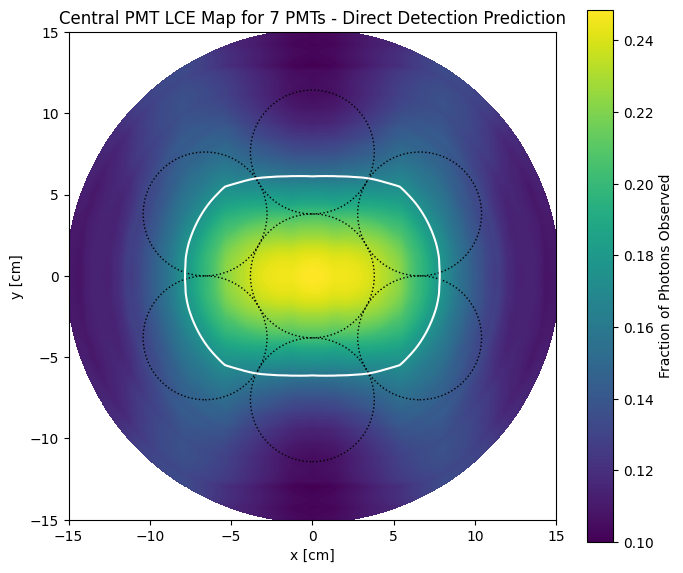

In [27]:
# Use exactly the same code to compare to 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import RegularGridInterpolator
def tmp():
    hits_q = single_pmt_response.copy()
    xs = x
    ys = y
    # ---------------------------------------------------------------------------
    # 0.  full symmetric grid (keep 0 only once)
    # ---------------------------------------------------------------------------
    xs_pos = xs                              # [0,  Δx,  2Δx, …]
    xs_neg = -xs[1:][::-1]                   # [-Δx, -2Δx, …]  (same length – 1)

    xs_full = np.concatenate((xs_neg, xs_pos))   # length = 2*len(xs)-1
    ys_full = xs_full.copy()

    nxF, nyF = xs_full.size, ys_full.size
    i0 = len(xs_neg)                         # index of x = 0
    j0 = i0                                  # index of y = 0
    r_pmt = 7.62 / 2
    # ---------------------------------------------------------------------------
    # 1.  mirror the quarter-circle map into all four quadrants
    # ---------------------------------------------------------------------------
    full_map = np.full((nxF, nyF), np.nan)

    # positive-x / positive-y (original)
    full_map[i0:, j0:] = hits_q

    # negative-x / positive-y
    full_map[:i0, j0:] = hits_q[1:,:][::-1, :]

    # positive-x / negative-y
    full_map[i0:, :j0] = hits_q[:,1:][:, ::-1]

    # negative-x / negative-y
    full_map[:i0, :j0] = hits_q[1:,1:][::-1, ::-1]

    full_map = np.rot90(full_map)
    central_map = full_map
    # ----------------------------------


    # 1) make an interpolator over the full_map
    interp = RegularGridInterpolator(
        (xs_full, ys_full),
        full_map,
        method='linear',       # linear → no oscillation
        bounds_error=False,
        fill_value=np.nan
    )

    # 2) prepare a mesh of all (x,y) points once
    Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
    pts = np.stack([Xg.ravel(), Yg.ravel()], axis=-1)  # (N², 2)

    centres = [(0, 0)]                               # central tube

    R_hex = 2 * r_pmt
    angles = np.deg2rad([30, 90, 150, 210, 270, 330])
    for ang in angles:
        centres.append((R_hex * np.cos(ang), R_hex * np.sin(ang)))

    # 3) for each PMT center, sample the shifted map
    maps = []
    for (xc, yc) in centres:
        # to shift the map by +xc,+yc, we sample at (x - xc, y - yc)
        shifted_pts = pts - np.array([xc, yc])
        shifted_map = interp(shifted_pts).reshape(full_map.shape)
        maps.append(shifted_map)

    # 4) stack and ratio as before
    stack   = np.stack(maps)                     
    tot_map = np.nansum(stack, axis=0)
    ratio   = np.divide(
        maps[0], tot_map,
        out = np.full_like(tot_map, np.nan),
        where=~np.isnan(tot_map)
    )

    X, Y = np.meshgrid(xs_full, ys_full, indexing='ij')

    # 2) create mask for points outside max_extent
    outside = (X**2 + Y**2) > (2 * 7.62 )**2
    ratio[outside] = np.nan
    # --------------------------------------------------------------------------
    # 4.  plot
    # --------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(7, 6))

    im = ax.imshow(ratio.T,
                extent=[xs_full[0], xs_full[-1], ys_full[0], ys_full[-1]],
                origin='lower', aspect='equal', cmap='viridis',
                vmin=np.nanmin(ratio), vmax=np.nanmax(ratio), interpolation='bilinear')
    fig.colorbar(im, ax=ax, label='Fraction of Photons Observed')

    # draw rims
    for (xc, yc) in centres:
        ax.add_patch(Circle((xc, yc), r_pmt, fill=False, ls=':', color='k'))

    # --------------------------------------------------------------------------
    # 5.  66 % enclosed-signal contour for the CENTRAL map
    # --------------------------------------------------------------------------
    vals   = central_map[~np.isnan(central_map)].ravel()
    vals   = np.sort(vals)[::-1]                       # brightest → darkest
    cum    = np.cumsum(vals)
    thr    = vals[np.searchsorted(cum, 0.33 * cum[-1])]   # flux threshold

    # isolate the region whose central-tube value ≥ threshold
    cs = ax.contour(xs_full, ys_full, central_map.T,
                    levels=[thr], colors='w', linewidths=1.5)

    ax.legend(frameon=False, loc='upper right')
    path = cs.collections[0].get_paths()[0]          # the first (and only) closed path
    verts = path.vertices                            # (N, 2) array  [x, y]

    tol = dx / 2                                     # half-grid tolerance
    on_axis = np.isclose(verts[:, 1], 0.0, atol=tol) # points with y ≈ 0

    path  = cs.collections[0].get_paths()[0]     # closed contour for 66 %
    verts = path.vertices                        # (N, 2) points [x, y] in cm
    tol   = dx / 2                               # half-grid tolerance (~0.015 cm)

    # —— horizontal diameter  (intersections with  y ≈ 0) ——————
    on_y0 = np.isclose(verts[:, 1], 0.0, atol=tol)
    if np.any(on_y0):
        xs_axis    = verts[on_y0, 0]
        diam_y0_cm = xs_axis.max() - xs_axis.min()
        print(f"66 % contour width along y = 0 : {diam_y0_cm:.3f} cm")
    else:
        print("Contour does not cross y = 0")

    # —— vertical diameter  (intersections with  x ≈ 0) ————————
    on_x0 = np.isclose(verts[:, 0], 0.0, atol=tol)
    if np.any(on_x0):
        ys_axis    = verts[on_x0, 1]
        diam_x0_cm = ys_axis.max() - ys_axis.min()
        print(f"66 % contour height along x = 0 : {diam_x0_cm:.3f} cm")
    else:
        print("Contour does not cross x = 0")
    print(diam_x0_cm/diam_y0_cm)
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_title('Central PMT LCE Map for 7 PMTs - Direct Detection Prediction')
    plt.tight_layout()
    plt.show()
    return ratio
ratioDD = tmp()

50% contour width along y = 0 : 23.199 cm
50% contour height along x = 0 : 17.053 cm
Aspect ratio (height/width): 0.735


/tmp/ipykernel_169/51273641.py:177: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if len(contour_sets) > 0 and len(contour_sets[0].collections[0].get_paths()) > 0:
/tmp/ipykernel_169/51273641.py:179: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path = cs_33.collections[0].get_paths()[0]


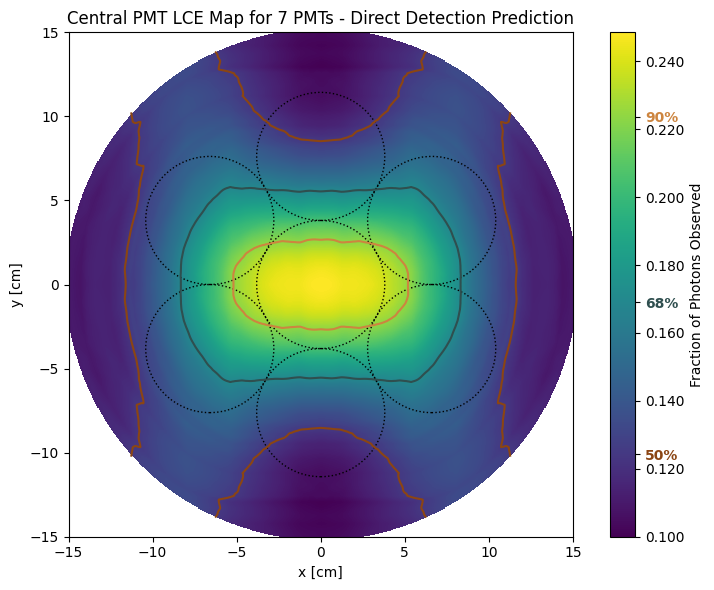

In [10]:
# Changed contours

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import RegularGridInterpolator
from matplotlib.lines import Line2D
from scipy.ndimage import zoom

def tmp():
    hits_q = single_pmt_response.copy()
    xs = x
    ys = y
    # ---------------------------------------------------------------------------
    # 0.  full symmetric grid (keep 0 only once)
    # ---------------------------------------------------------------------------
    xs_pos = xs                              # [0,  Δx,  2Δx, …]
    xs_neg = -xs[1:][::-1]                   # [-Δx, -2Δx, …]  (same length – 1)

    xs_full = np.concatenate((xs_neg, xs_pos))   # length = 2*len(xs)-1
    ys_full = xs_full.copy()

    nxF, nyF = xs_full.size, ys_full.size
    i0 = len(xs_neg)                         # index of x = 0
    j0 = i0                                  # index of y = 0
    r_pmt = 7.62 / 2
    # ---------------------------------------------------------------------------
    # 1.  mirror the quarter-circle map into all four quadrants
    # ---------------------------------------------------------------------------
    full_map = np.full((nxF, nyF), np.nan)

    # positive-x / positive-y (original)
    full_map[i0:, j0:] = hits_q

    # negative-x / positive-y
    full_map[:i0, j0:] = hits_q[1:,:][::-1, :]

    # positive-x / negative-y
    full_map[i0:, :j0] = hits_q[:,1:][:, ::-1]

    # negative-x / negative-y
    full_map[:i0, :j0] = hits_q[1:,1:][::-1, ::-1]

    full_map = np.rot90(full_map)
    central_map = full_map
    # ----------------------------------

    # 1) make an interpolator over the full_map
    interp = RegularGridInterpolator(
        (xs_full, ys_full),
        full_map,
        method='linear',       # linear → no oscillation
        bounds_error=False,
        fill_value=np.nan
    )

    # 2) prepare a mesh of all (x,y) points once
    Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
    pts = np.stack([Xg.ravel(), Yg.ravel()], axis=-1)  # (N², 2)

    centres = [(0, 0)]                               # central tube

    R_hex = 2 * r_pmt
    angles = np.deg2rad([30, 90, 150, 210, 270, 330])
    for ang in angles:
        centres.append((R_hex * np.cos(ang), R_hex * np.sin(ang)))

    # 3) for each PMT center, sample the shifted map
    maps = []
    for (xc, yc) in centres:
        # to shift the map by +xc,+yc, we sample at (x - xc, y - yc)
        shifted_pts = pts - np.array([xc, yc])
        shifted_map = interp(shifted_pts).reshape(full_map.shape)
        maps.append(shifted_map)

    # 4) stack and ratio as before
    stack   = np.stack(maps)                     
    tot_map = np.nansum(stack, axis=0)
    ratio   = np.divide(
        maps[0], tot_map,
        out = np.full_like(tot_map, np.nan),
        where=~np.isnan(tot_map)
    )

    X, Y = np.meshgrid(xs_full, ys_full, indexing='ij')

    # 2) create mask for points outside max_extent
    outside = (X**2 + Y**2) > (2 * 7.62 )**2
    ratio[outside] = np.nan
    
    # --------------------------------------------------------------------------
    # 4.  plot
    # --------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.imshow(ratio.T,
                extent=[xs_full[0], xs_full[-1], ys_full[0], ys_full[-1]],
                origin='lower', aspect='equal', cmap='viridis',
                vmin=np.nanmin(ratio), vmax=np.nanmax(ratio), interpolation='bilinear')
    
    # Create colorbar
    cbar = fig.colorbar(im, ax=ax, label='Fraction of Photons Observed')

    # draw rims
    for (xc, yc) in centres:
        ax.add_patch(Circle((xc, yc), r_pmt, fill=False, ls=':', color='k'))

    # --------------------------------------------------------------------------
    # 5.  Multiple contour levels for the ratio map (corrected approach)
    # --------------------------------------------------------------------------
    
    # Smooth the ratio map for better contours
    zoom_factor = 3
    ratio_smooth = zoom(ratio, zoom_factor, order=1)
    xs_smooth = np.linspace(xs_full[0], xs_full[-1], len(xs_full) * zoom_factor)
    ys_smooth = np.linspace(ys_full[0], ys_full[-1], len(ys_full) * zoom_factor)
    
    # Calculate contours relative to maximum ratio value
    max_ratio = np.nanmax(ratio)
    contour_percentages = [0.50, 0.68, 0.9]  # 33%, 68%, 90% of max
    contour_colors = ['#8B4513', '#2F4F4F', '#CD853F']  # darker muted colors
    contour_labels = ['50%', '68%', '90%']
    
    # Calculate thresholds as percentages of maximum
    thresholds = [pct * max_ratio for pct in contour_percentages]
    
    # Draw all contours with smooth, bold lines
    contour_sets = []
    for i, (threshold, color, label) in enumerate(zip(thresholds, contour_colors, contour_labels)):
        cs = ax.contour(xs_smooth, ys_smooth, ratio_smooth.T,
                       levels=[threshold], colors=[color], linewidths=1.5, alpha=1.0)
        contour_sets.append(cs)
    
    # Store the original colorbar limits before modifying ticks
    vmin, vmax = im.get_clim()

    # Add contour level indicators to the colorbar
    cbar_ticks = list(cbar.get_ticks())  # Get existing ticks
    cbar_labels = [f'{tick:.3f}' for tick in cbar_ticks]  # Existing labels

    # Add threshold values as additional ticks
    for threshold, color, label in zip(thresholds, contour_colors, contour_labels):
        if threshold not in cbar_ticks:  # Avoid duplicates
            cbar_ticks.append(threshold)
            cbar_labels.append(f'{label}')

    # Sort ticks and labels together
    tick_label_pairs = list(zip(cbar_ticks, cbar_labels))
    tick_label_pairs.sort(key=lambda x: x[0])
    sorted_ticks, sorted_labels = zip(*tick_label_pairs)

    # Filter ticks to only include those within the colorbar range
    filtered_ticks = []
    filtered_labels = []
    for tick, label in zip(sorted_ticks, sorted_labels):
        if vmin <= tick <= vmax:
            filtered_ticks.append(tick)
            filtered_labels.append(label)

    # Set the ticks and labels
    cbar.set_ticks(filtered_ticks)
    cbar.set_ticklabels(filtered_labels)

    # Restore the original colorbar limits
    im.set_clim(vmin, vmax)

    # Color the threshold tick labels to match contours
    for i, (tick, label) in enumerate(zip(filtered_ticks, filtered_labels)):
        if label in contour_labels:
            color_idx = contour_labels.index(label)
            cbar.ax.get_yticklabels()[i].set_color(contour_colors[color_idx])
            cbar.ax.get_yticklabels()[i].set_fontweight('bold')

    # Create custom legend for contours
    
    # Calculate and print dimensions for the 33% contour
    if len(contour_sets) > 0 and len(contour_sets[0].collections[0].get_paths()) > 0:
        cs_33 = contour_sets[0]  # 33% contour
        path = cs_33.collections[0].get_paths()[0]
        verts = path.vertices
        
        tol = (xs_full[1] - xs_full[0]) / 2  # half-grid tolerance
        
        # Horizontal diameter (intersections with y ≈ 0)
        on_y0 = np.isclose(verts[:, 1], 0.0, atol=tol)
        if np.any(on_y0):
            xs_axis = verts[on_y0, 0]
            diam_y0_cm = xs_axis.max() - xs_axis.min()
            print(f"{contour_labels[0]} contour width along y = 0 : {diam_y0_cm:.3f} cm")
        else:
            print("{} contour does not cross y = 0".format(contour_labels[0]))

        # Vertical diameter (intersections with x ≈ 0)
        on_x0 = np.isclose(verts[:, 0], 0.0, atol=tol)
        if np.any(on_x0):
            ys_axis = verts[on_x0, 1]
            diam_x0_cm = ys_axis.max() - ys_axis.min()
            print(f"{contour_labels[0]} contour height along x = 0 : {diam_x0_cm:.3f} cm")
            print(f"Aspect ratio (height/width): {diam_x0_cm/diam_y0_cm:.3f}")
        else:
            print("{} contour does not cross x = 0".format(contour_labels[0]))
    
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_title('Central PMT LCE Map for 7 PMTs - Direct Detection Prediction')
    plt.tight_layout()
    plt.show()
    return ratio

ratioDD = tmp()

(0.03295033375084047, -0.036068140313244235, 0.013372303579348724)

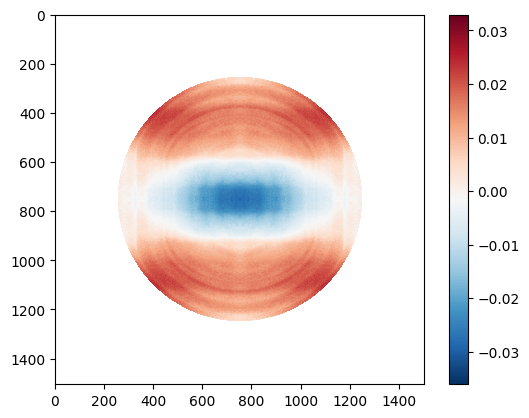

In [29]:
map1 = ratioDD
map2 = ratio_MC

diff_map = map1 - map2
max_diff = np.nanmax(diff_map)
min_diff = np.nanmin(diff_map)
plt.imshow(diff_map, cmap='RdBu_r', vmin=min_diff, vmax=max_diff)
plt.colorbar()
rmse = np.sqrt(np.nanmean((map1 - map2)**2))

max_diff, min_diff, rmse

/tmp/ipykernel_169/3994903644.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


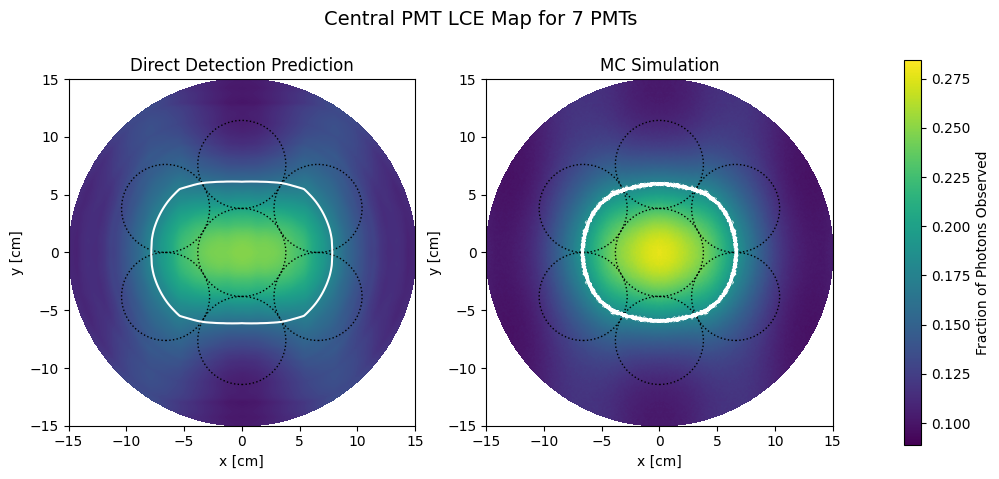

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import RegularGridInterpolator
import matplotlib.gridspec as gridspec

def plot_pmt_comparison():
    # First function - Direct Detection
    def generate_ratio_DD():
        hits_q = single_pmt_response.copy()
        xs = x
        ys = y
        
        xs_pos = xs                              
        xs_neg = -xs[1:][::-1]                   

        xs_full = np.concatenate((xs_neg, xs_pos))   
        ys_full = xs_full.copy()

        nxF, nyF = xs_full.size, ys_full.size
        i0 = len(xs_neg)                         
        j0 = i0                                  
        r_pmt = 7.62 / 2
        
        full_map = np.full((nxF, nyF), np.nan)

        # Mirror into all four quadrants
        full_map[i0:, j0:] = hits_q
        full_map[:i0, j0:] = hits_q[1:,:][::-1, :]
        full_map[i0:, :j0] = hits_q[:,1:][:, ::-1]
        full_map[:i0, :j0] = hits_q[1:,1:][::-1, ::-1]

        full_map = np.rot90(full_map)
        central_map = full_map

        # Make interpolator
        interp = RegularGridInterpolator(
            (xs_full, ys_full),
            full_map,
            method='linear',
            bounds_error=False,
            fill_value=np.nan
        )

        # Prepare mesh
        Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
        pts = np.stack([Xg.ravel(), Yg.ravel()], axis=-1)

        centres = [(0, 0)]                               

        R_hex = 2 * r_pmt
        angles = np.deg2rad([30, 90, 150, 210, 270, 330])
        for ang in angles:
            centres.append((R_hex * np.cos(ang), R_hex * np.sin(ang)))

        # Sample shifted maps
        maps = []
        for (xc, yc) in centres:
            shifted_pts = pts - np.array([xc, yc])
            shifted_map = interp(shifted_pts).reshape(full_map.shape)
            maps.append(shifted_map)

        # Stack and ratio
        stack = np.stack(maps)                     
        tot_map = np.nansum(stack, axis=0)
        ratio = np.divide(
            maps[0], tot_map,
            out = np.full_like(tot_map, np.nan),
            where=~np.isnan(tot_map)
        )

        X, Y = np.meshgrid(xs_full, ys_full, indexing='ij')
        outside = (X**2 + Y**2) > (2 * 7.62)**2
        ratio[outside] = np.nan
        
        return ratio, xs_full, ys_full, centres, r_pmt, central_map

    # Second function - MC simulation
    def generate_ratio_MC():
        hits_q = np.load('./ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch_z_weighted.npz')['arr_0'][:,:,0].copy()

        xs_pos = xs                              
        xs_neg = -xs[1:][::-1]                   

        xs_full = np.concatenate((xs_neg, xs_pos))   
        ys_full = xs_full.copy()

        nxF, nyF = xs_full.size, ys_full.size
        i0 = len(xs_neg)                         
        j0 = i0                                  
        r_pmt = 7.62 / 2
        
        full_map = np.full((nxF, nyF), np.nan)

        # Mirror into all four quadrants
        full_map[i0:, j0:] = hits_q
        full_map[:i0, j0:] = hits_q[1:,:][::-1, :]
        full_map[i0:, :j0] = hits_q[:,1:][:, ::-1]
        full_map[:i0, :j0] = hits_q[1:,1:][::-1, ::-1]

        central_map = full_map

        # Make interpolator
        interp = RegularGridInterpolator(
            (xs_full, ys_full),
            full_map,
            method='linear',
            bounds_error=False,
            fill_value=np.nan
        )

        # Prepare mesh
        Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
        pts = np.stack([Xg.ravel(), Yg.ravel()], axis=-1)

        centres = [(0, 0)]                               

        R_hex = 2 * r_pmt
        angles = np.deg2rad([30, 90, 150, 210, 270, 330])
        for ang in angles:
            centres.append((R_hex * np.cos(ang), R_hex * np.sin(ang)))

        # Sample shifted maps
        maps = []
        for (xc, yc) in centres:
            shifted_pts = pts - np.array([xc, yc])
            shifted_map = interp(shifted_pts).reshape(full_map.shape)
            maps.append(shifted_map)

        # Stack and ratio
        stack = np.stack(maps)                     
        tot_map = np.nansum(stack, axis=0)
        ratio = np.divide(
            maps[0], tot_map,
            out = np.full_like(tot_map, np.nan),
            where=~np.isnan(tot_map)
        )

        X, Y = np.meshgrid(xs_full, ys_full, indexing='ij')
        outside = (X**2 + Y**2) > (2 * 7.62)**2
        ratio[outside] = np.nan
        
        return ratio, xs_full, ys_full, centres, r_pmt, central_map

    # Generate both datasets
    ratio_DD, xs_full, ys_full, centres, r_pmt, central_map_DD = generate_ratio_DD()
    ratio_MC, xs_full, ys_full, centres, r_pmt, central_map_MC = generate_ratio_MC()

    # Find common colorbar limits
    vmin = min(np.nanmin(ratio_DD), np.nanmin(ratio_MC))
    vmax = max(np.nanmax(ratio_DD), np.nanmax(ratio_MC))

    # Create figure with gridspec
    fig = plt.figure(figsize=(11, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)

    # First subplot - Direct Detection
    ax1 = fig.add_subplot(gs[0])
    im1 = ax1.imshow(ratio_DD.T,
                     extent=[xs_full[0], xs_full[-1], ys_full[0], ys_full[-1]],
                     origin='lower', aspect='equal', cmap='viridis',
                     vmin=vmin, vmax=vmax, interpolation='bicubic')

    # Draw PMT rims
    for (xc, yc) in centres:
        ax1.add_patch(Circle((xc, yc), r_pmt, fill=False, ls=':', color='k'))

    # Add 66% contour for DD
    vals = central_map_DD[~np.isnan(central_map_DD)].ravel()
    vals = np.sort(vals)[::-1]
    cum = np.cumsum(vals)
    thr = vals[np.searchsorted(cum, 0.33 * cum[-1])]
    cs1 = ax1.contour(xs_full, ys_full, central_map_DD.T,
                      levels=[thr], colors='w', linewidths=1.5)

    ax1.set_xlabel('x [cm]')
    ax1.set_ylabel('y [cm]')
    ax1.set_xlim(-15, 15)
    ax1.set_ylim(-15, 15)
    ax1.set_title('Direct Detection Prediction')

    # Second subplot - MC simulation
    ax2 = fig.add_subplot(gs[1])
    im2 = ax2.imshow(ratio_MC.T,
                     extent=[xs_full[0], xs_full[-1], ys_full[0], ys_full[-1]],
                     origin='lower', aspect='equal', cmap='viridis',
                     vmin=vmin, vmax=vmax, interpolation='bicubic')

    # Draw PMT rims
    for (xc, yc) in centres:
        ax2.add_patch(Circle((xc, yc), r_pmt, fill=False, ls=':', color='k'))

    # Add 66% contour for MC
    vals = central_map_MC[~np.isnan(central_map_MC)].ravel()
    vals = np.sort(vals)[::-1]
    cum = np.cumsum(vals)
    thr = vals[np.searchsorted(cum, 0.33 * cum[-1])]
    cs2 = ax2.contour(xs_full, ys_full, central_map_MC.T,
                      levels=[thr], colors='w', linewidths=1.5)

    ax2.set_xlabel('x [cm]')
    ax2.set_ylabel('y [cm]')
    ax2.set_xlim(-15, 15)
    ax2.set_ylim(-15, 15)
    ax2.set_title('MC Simulation')

    # Third subplot - colorbar
    cax = fig.add_subplot(gs[2])
    cbar = plt.colorbar(im1, cax=cax)
    cbar.set_label('Fraction of Photons Observed')

    # Add overall title
    fig.suptitle('Central PMT LCE Map for 7 PMTs', fontsize=14, y=0.98)

    plt.tight_layout()
    plt.show()

    return ratio_DD, ratio_MC

# Call the function
ratio_DD, ratio_MC = plot_pmt_comparison()

/tmp/ipykernel_169/647662023.py:280: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


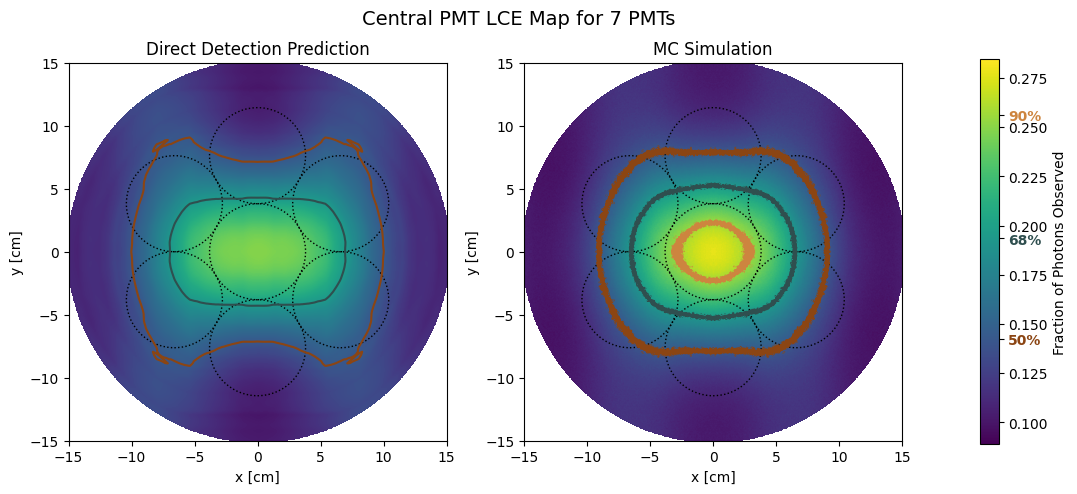

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import RegularGridInterpolator
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.ndimage import zoom

def plot_pmt_comparison():
    # First function - Direct Detection
    def generate_ratio_DD():
        hits_q = single_pmt_response.copy()
        xs = x
        ys = y
        
        xs_pos = xs                              
        xs_neg = -xs[1:][::-1]                   

        xs_full = np.concatenate((xs_neg, xs_pos))   
        ys_full = xs_full.copy()

        nxF, nyF = xs_full.size, ys_full.size
        i0 = len(xs_neg)                         
        j0 = i0                                  
        r_pmt = 7.62 / 2
        
        full_map = np.full((nxF, nyF), np.nan)

        # Mirror into all four quadrants
        full_map[i0:, j0:] = hits_q
        full_map[:i0, j0:] = hits_q[1:,:][::-1, :]
        full_map[i0:, :j0] = hits_q[:,1:][:, ::-1]
        full_map[:i0, :j0] = hits_q[1:,1:][::-1, ::-1]

        full_map = np.rot90(full_map)
        central_map = full_map

        # Make interpolator
        interp = RegularGridInterpolator(
            (xs_full, ys_full),
            full_map,
            method='linear',
            bounds_error=False,
            fill_value=np.nan
        )

        # Prepare mesh
        Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
        pts = np.stack([Xg.ravel(), Yg.ravel()], axis=-1)

        centres = [(0, 0)]                               

        R_hex = 2 * r_pmt
        angles = np.deg2rad([30, 90, 150, 210, 270, 330])
        for ang in angles:
            centres.append((R_hex * np.cos(ang), R_hex * np.sin(ang)))

        # Sample shifted maps
        maps = []
        for (xc, yc) in centres:
            shifted_pts = pts - np.array([xc, yc])
            shifted_map = interp(shifted_pts).reshape(full_map.shape)
            maps.append(shifted_map)

        # Stack and ratio
        stack = np.stack(maps)                     
        tot_map = np.nansum(stack, axis=0)
        ratio = np.divide(
            maps[0], tot_map,
            out = np.full_like(tot_map, np.nan),
            where=~np.isnan(tot_map)
        )

        X, Y = np.meshgrid(xs_full, ys_full, indexing='ij')
        outside = (X**2 + Y**2) > (2 * 7.62)**2
        ratio[outside] = np.nan
        
        return ratio, xs_full, ys_full, centres, r_pmt, central_map

    # Second function - MC simulation
    def generate_ratio_MC():
        hits_q = np.load('./ownMCS2EmissionPlots/MC_realistic_S2Emission_wire_switch_z_weighted.npz')['arr_0'][:,:,0].copy()

        xs_pos = xs                              
        xs_neg = -xs[1:][::-1]                   

        xs_full = np.concatenate((xs_neg, xs_pos))   
        ys_full = xs_full.copy()

        nxF, nyF = xs_full.size, ys_full.size
        i0 = len(xs_neg)                         
        j0 = i0                                  
        r_pmt = 7.62 / 2
        
        full_map = np.full((nxF, nyF), np.nan)

        # Mirror into all four quadrants
        full_map[i0:, j0:] = hits_q
        full_map[:i0, j0:] = hits_q[1:,:][::-1, :]
        full_map[i0:, :j0] = hits_q[:,1:][:, ::-1]
        full_map[:i0, :j0] = hits_q[1:,1:][::-1, ::-1]

        central_map = full_map

        # Make interpolator
        interp = RegularGridInterpolator(
            (xs_full, ys_full),
            full_map,
            method='linear',
            bounds_error=False,
            fill_value=np.nan
        )

        # Prepare mesh
        Xg, Yg = np.meshgrid(xs_full, ys_full, indexing='ij')
        pts = np.stack([Xg.ravel(), Yg.ravel()], axis=-1)

        centres = [(0, 0)]                               

        R_hex = 2 * r_pmt
        angles = np.deg2rad([30, 90, 150, 210, 270, 330])
        for ang in angles:
            centres.append((R_hex * np.cos(ang), R_hex * np.sin(ang)))

        # Sample shifted maps
        maps = []
        for (xc, yc) in centres:
            shifted_pts = pts - np.array([xc, yc])
            shifted_map = interp(shifted_pts).reshape(full_map.shape)
            maps.append(shifted_map)

        # Stack and ratio
        stack = np.stack(maps)                     
        tot_map = np.nansum(stack, axis=0)
        ratio = np.divide(
            maps[0], tot_map,
            out = np.full_like(tot_map, np.nan),
            where=~np.isnan(tot_map)
        )

        X, Y = np.meshgrid(xs_full, ys_full, indexing='ij')
        outside = (X**2 + Y**2) > (2 * 7.62)**2
        ratio[outside] = np.nan
        
        return ratio, xs_full, ys_full, centres, r_pmt, central_map

    # Function to add enhanced contours to an axis
    def add_enhanced_contours(ax, ratio, xs_full, ys_full, shared_vmax):
        # Smooth the ratio map for better contours
        zoom_factor = 3
        ratio_smooth = zoom(ratio, zoom_factor, order=1)
        xs_smooth = np.linspace(xs_full[0], xs_full[-1], len(xs_full) * zoom_factor)
        ys_smooth = np.linspace(ys_full[0], ys_full[-1], len(ys_full) * zoom_factor)
        
        # Calculate contours relative to SHARED maximum ratio value
        contour_percentages = [0.50, 0.68, 0.9]  # 50%, 68%, 90% of shared max
        contour_colors = ['#8B4513', '#2F4F4F', '#CD853F']  # darker muted colors
        contour_labels = ['50%', '68%', '90%']
        
        # Calculate thresholds as percentages of SHARED maximum
        thresholds = [pct * shared_vmax for pct in contour_percentages]
        
        # Draw all contours with smooth, bold lines
        contour_sets = []
        for i, (threshold, color, label) in enumerate(zip(thresholds, contour_colors, contour_labels)):
            cs = ax.contour(xs_smooth, ys_smooth, ratio_smooth.T,
                           levels=[threshold], colors=[color], linewidths=1.5, alpha=1.0)
            contour_sets.append(cs)
        
        return contour_colors, contour_labels

    # Generate both datasets
    ratio_DD, xs_full, ys_full, centres, r_pmt, central_map_DD = generate_ratio_DD()
    ratio_MC, xs_full, ys_full, centres, r_pmt, central_map_MC = generate_ratio_MC()

    # Find common colorbar limits
    vmin = min(np.nanmin(ratio_DD), np.nanmin(ratio_MC))
    vmax = max(np.nanmax(ratio_DD), np.nanmax(ratio_MC))

    # Create figure with gridspec
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)

    # First subplot - Direct Detection
    ax1 = fig.add_subplot(gs[0])
    im1 = ax1.imshow(ratio_DD.T,
                     extent=[xs_full[0], xs_full[-1], ys_full[0], ys_full[-1]],
                     origin='lower', aspect='equal', cmap='viridis',
                     vmin=vmin, vmax=vmax, interpolation='bilinear')

    # Draw PMT rims
    for (xc, yc) in centres:
        ax1.add_patch(Circle((xc, yc), r_pmt, fill=False, ls=':', color='k'))

    # Add enhanced contours for DD
    contour_colors, contour_labels = add_enhanced_contours(ax1, ratio_DD, xs_full, ys_full, vmax)

    ax1.set_xlabel('x [cm]')
    ax1.set_ylabel('y [cm]')
    ax1.set_xlim(-15, 15)
    ax1.set_ylim(-15, 15)
    ax1.set_title('Direct Detection Prediction')

    # Second subplot - MC simulation
    ax2 = fig.add_subplot(gs[1])
    im2 = ax2.imshow(ratio_MC.T,
                     extent=[xs_full[0], xs_full[-1], ys_full[0], ys_full[-1]],
                     origin='lower', aspect='equal', cmap='viridis',
                     vmin=vmin, vmax=vmax, interpolation='bilinear')

    # Draw PMT rims
    for (xc, yc) in centres:
        ax2.add_patch(Circle((xc, yc), r_pmt, fill=False, ls=':', color='k'))

    # Add enhanced contours for MC
    add_enhanced_contours(ax2, ratio_MC, xs_full, ys_full, vmax)

    ax2.set_xlabel('x [cm]')
    ax2.set_ylabel('y [cm]')
    ax2.set_xlim(-15, 15)
    ax2.set_ylim(-15, 15)
    ax2.set_title('MC Simulation')

    # Third subplot - colorbar
    cax = fig.add_subplot(gs[2])
    cbar = plt.colorbar(im1, cax=cax)
    cbar.set_label('Fraction of Photons Observed')

    # Calculate shared thresholds for colorbar annotation based on shared vmax
    contour_percentages = [0.50, 0.68, 0.9]
    thresholds_combined = [pct * vmax for pct in contour_percentages]  # Use shared vmax

    # Store the original colorbar limits (use vmin, vmax from shared scale)
    vmin_cbar, vmax_cbar = vmin, vmax

    # Add contour level indicators to the colorbar
    cbar_ticks = list(cbar.get_ticks())
    cbar_labels_list = [f'{tick:.3f}' for tick in cbar_ticks]

    # Add threshold values as additional ticks
    for threshold, color, label in zip(thresholds_combined, contour_colors, contour_labels):
        if threshold not in cbar_ticks:
            cbar_ticks.append(threshold)
            cbar_labels_list.append(f'{label}')

    # Sort ticks and labels together
    tick_label_pairs = list(zip(cbar_ticks, cbar_labels_list))
    tick_label_pairs.sort(key=lambda x: x[0])
    sorted_ticks, sorted_labels = zip(*tick_label_pairs)

    # Filter ticks to only include those within the colorbar range
    filtered_ticks = []
    filtered_labels = []
    for tick, label in zip(sorted_ticks, sorted_labels):
        if vmin_cbar <= tick <= vmax_cbar:
            filtered_ticks.append(tick)
            filtered_labels.append(label)

    # Set the ticks and labels
    cbar.set_ticks(filtered_ticks)
    cbar.set_ticklabels(filtered_labels)

    # Color the threshold tick labels to match contours
    for i, (tick, label) in enumerate(zip(filtered_ticks, filtered_labels)):
        if label in contour_labels:
            color_idx = contour_labels.index(label)
            cbar.ax.get_yticklabels()[i].set_color(contour_colors[color_idx])
            cbar.ax.get_yticklabels()[i].set_fontweight('bold')

    # Create custom legend for contours (add to second plot to avoid crowding)
    legend_elements = []
    for color, label in zip(contour_colors, contour_labels):
        legend_elements.append(Line2D([0], [0], color=color, linewidth=2, 
                                    label=f'{label} of max signal'))
    

    # Add overall title
    fig.suptitle('Central PMT LCE Map for 7 PMTs', fontsize=14, y=0.98)

    plt.tight_layout()
    plt.show()

    return ratio_DD, ratio_MC

# Call the function
ratio_DD, ratio_MC = plot_pmt_comparison()

In [40]:
def tmp(path):
    # SR2 Processed data 
    tmp = []
    for i in os.listdir(path):
        if not os.path.isdir(os.path.join(path, i)):
            tmp +=  [np.load(os.path.join(path, i))['arr_0']]
    tmp = np.concatenate(tmp)
    # Return all top pmt entries
    return np.column_stack([tmp['s2_x_cnf'], tmp['s2_y_cnf']]), tmp['s2_area_per_channel'][:,:np.maximum(np.max(not_dead_pmts), np.max(dead_pmts))+1]
seed = np.random.randint(0, 100000)
data_path = "/Code/processed_data/new_Kr"#os.path.join(data_path)
pos_cnf, patterns_real = tmp(data_path)

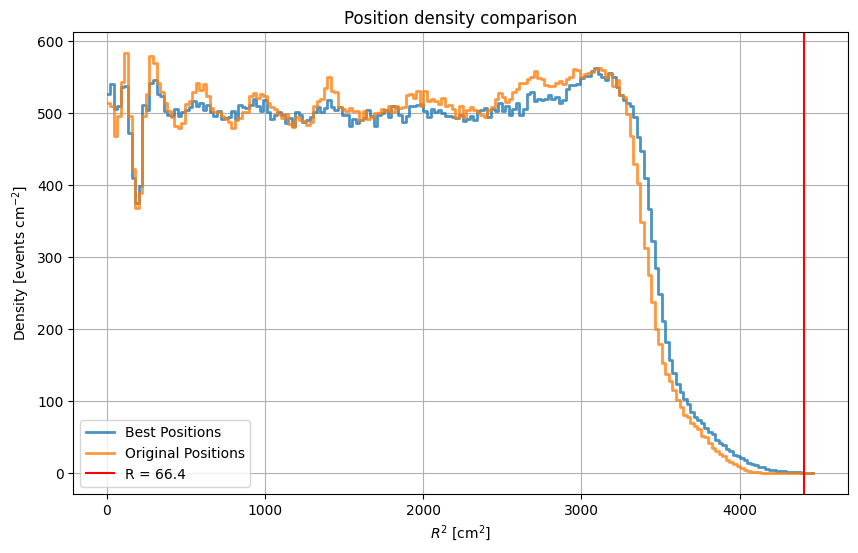

In [56]:
pos = np.load(os.path.join(pos_refit_path, "iterative_encoder_search_0.npz"))['arr_0']
# Calculate R² for both datasets
r2 = pos[:,0]**2 + pos[:,1]**2
r2_cnf = pos_cnf[:,0]**2 + pos_cnf[:,1]**2
# Use the same bins for both to ensure fair comparison
r2_over_pi_combined = np.concatenate([r2/np.pi, r2_cnf/np.pi])
bins = np.linspace(r2_over_pi_combined.min(), r2_over_pi_combined.max(), 200)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers *= np.pi
# Process first dataset
r2_over_pi = r2 / np.pi
counts, _ = np.histogram(r2_over_pi, bins=bins)
bin_widths = bins[1:] - bins[:-1]
bin_areas = np.pi * bin_widths
density = counts / bin_areas
# Process second dataset
r2_over_pi_cnf = r2_cnf / np.pi
counts_cnf, _ = np.histogram(r2_over_pi_cnf, bins=bins)
density_cnf = counts_cnf / bin_areas # Same bin_areas
# Plot both on same figure
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, density, drawstyle='steps-mid', label='Best Positions', linewidth=2, alpha=0.8)
plt.plot(bin_centers, density_cnf, drawstyle='steps-mid', label='Original Positions', linewidth=2, alpha=0.8)
plt.axvline(66.4**2, label='R = 66.4', c='red')
plt.xlabel(r'$R^2$ [cm$^{2}$]')  # Added units here too
plt.ylabel(r'Density [events cm$^{-2}$]')  # Added explicit units
plt.title(r'Position density comparison')
plt.legend()
plt.grid(True)
plt.show()